# Homework 1 – Data Analysis in Business (Variant 20)




In [18]:
# Setup
import os, glob, warnings, random, math, io
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE

plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 11

SEED = 20
random.seed(SEED); np.random.seed(SEED)
print("Environment ready. SEED =", SEED)

Environment ready. SEED = 20


## Part 1 — EDA & Data Preparation

### 1. Load data

In [19]:
# Auto-detect main CSV
DATA_PATH = ''
PARAMS_PATH = ''

csvs = sorted(glob.glob('*.csv'))

desc_patterns = ['описание параметров', 'description of parameters', 'sas_2022_hw1', 'parameters']
for c in csvs:
    low = c.lower()
    if any(p in low for p in desc_patterns):
        PARAMS_PATH = c

for c in csvs:
    if c != PARAMS_PATH:
        DATA_PATH = c
        break

print("Detected -> DATA_PATH:", DATA_PATH, "| PARAMS_PATH:", PARAMS_PATH)
if not DATA_PATH:
    raise FileNotFoundError("Main dataset CSV not found.")

# Robust CSV reader: try multiple separators & decimal marks
def read_csv_robust(path):
    # Try native sniff (python engine)
    try:
        df = pd.read_csv(path, sep=None, engine='python', low_memory=False)
        if df.shape[1] > 1:
            return df, {'sep':'auto', 'decimal':None}
    except Exception:
        pass
    # Try semicolon with comma-decimal
    try:
        df = pd.read_csv(path, sep=';', decimal=',', low_memory=False)
        if df.shape[1] > 1:
            return df, {'sep':';', 'decimal':','}
    except Exception:
        pass
    # Try semicolon with dot-decimal
    try:
        df = pd.read_csv(path, sep=';', decimal='.', low_memory=False)
        if df.shape[1] > 1:
            return df, {'sep':';', 'decimal':'.'}
    except Exception:
        pass
    # Try comma with comma-decimal (unlikely)
    try:
        df = pd.read_csv(path, sep=',', decimal=',', low_memory=False)
        if df.shape[1] > 1:
            return df, {'sep':',', 'decimal':','}
    except Exception:
        pass
    # Try tab
    try:
        df = pd.read_csv(path, sep='\t', low_memory=False)
        if df.shape[1] > 1:
            return df, {'sep':'\\t', 'decimal':None}
    except Exception:
        pass
    # Fallback default
    df = pd.read_csv(path, low_memory=False)
    return df, {'sep':'default', 'decimal':None}

df_raw, read_info = read_csv_robust(DATA_PATH)
df = df_raw.copy()
print("Read settings:", read_info, "| Shape:", df.shape)
display(df.head(5))

Detected -> DATA_PATH: HW1_var_20.csv | PARAMS_PATH: 
Read settings: {'sep': ';', 'decimal': ','} | Shape: (10242, 44)


,Номер варианта,ID,INCOME_BASE_TYPE,CREDIT_PURPOSE,INSURANCE_FLAG,DTI,SEX,FULL_AGE_CHILD_NUMBER,DEPENDANT_NUMBER,EDUCATION,...,own_closed,min_MnthAfterLoan,max_MnthAfterLoan,dlq_exist,thirty_in_a_year,sixty_in_a_year,ninety_in_a_year,thirty_vintage,sixty_vintage,ninety_vintage
0,20,1000020,2НДФЛ,Ремонт,1,0.35,женский,1,0,второе высшее,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20,1000040,2НДФЛ,Ремонт,1,0.49,мужской,0,0,среднее-специальное,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20,1000060,2НДФЛ,Ремонт,0,0.32,мужской,0,0,высшее,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20,1000080,Поступление зарплаты на счет,Ремонт,1,0.59,женский,1,0,Высшее/Второе высшее/Ученая степень,...,0.0,5.0,72.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,20,1000100,2НДФЛ,Ремонт,1,0.58,женский,0,0,высшее,...,0.0,1.0,89.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# Optional: parameter dictionary
params = None
if PARAMS_PATH:
    try:
        params = pd.read_csv(PARAMS_PATH)
        print("Parameter dictionary:", PARAMS_PATH, "| shape:", params.shape)
        display(params.head(10))
    except Exception as e:
        print("Failed to load parameter dictionary:", e)

### 2. Structure & missingness

In [21]:
overview = pd.DataFrame({
    'column': df.columns,
    'dtype': df.dtypes.astype(str),
    'n_unique': [df[c].nunique(dropna=True) for c in df.columns],
    'n_missing': df.isna().sum().values,
    'pct_missing': 100*df.isna().mean().values
})
display(overview.sort_values(['pct_missing','n_unique'], ascending=[False, True]))

,column,dtype,n_unique,n_missing,pct_missing
avg_num_delay,avg_num_delay,object,1146,6645,64.879906
if_zalog,if_zalog,float64,2,6633,64.762742
dlq_exist,dlq_exist,float64,2,6633,64.762742
thirty_in_a_year,thirty_in_a_year,float64,2,6633,64.762742
sixty_in_a_year,sixty_in_a_year,float64,2,6633,64.762742
ninety_in_a_year,ninety_in_a_year,float64,2,6633,64.762742
thirty_vintage,thirty_vintage,float64,2,6633,64.762742
sixty_vintage,sixty_vintage,float64,2,6633,64.762742
ninety_vintage,ninety_vintage,float64,2,6633,64.762742
num_AccountActive60,num_AccountActive60,float64,4,6633,64.762742


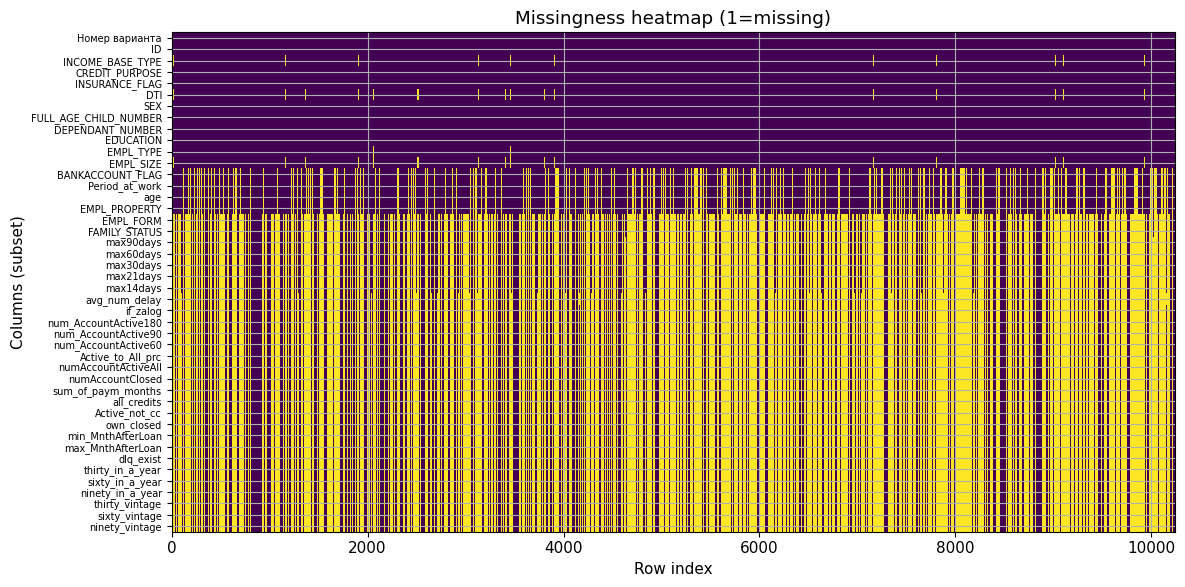

In [22]:
# Missingness heatmap (subset for readability)
ms = df.isna().astype(int)
sub_cols = list(ms.columns[:min(60, ms.shape[1])])
plt.figure(figsize=(12,6))
plt.imshow(ms[sub_cols].values.T, aspect='auto', interpolation='nearest')
plt.title('Missingness heatmap (1=missing)')
plt.xlabel('Row index'); plt.ylabel('Columns (subset)')
plt.yticks(range(len(sub_cols)), sub_cols, fontsize=7)
plt.tight_layout(); plt.show()

### 3. Cleaning & typing

In [23]:
# Identify ID & Variant
id_like = [c for c in df.columns if c.lower() in ['id','client_id','customer_id']]
variant_like = [c for c in df.columns if 'variant' in c.lower() or c.lower()=='var']
ID_COL = id_like[0] if id_like else ('ID' if 'ID' in df.columns else None)
id_series = df[ID_COL].copy() if ID_COL else pd.Series(range(1, len(df)+1), name='ID_auto')

# Normalize placeholders
for c in df.columns:
    if df[c].dtype == object:
        df[c] = df[c].replace(['*n.a.*','n.a.','N/A','NA','na','NaN','nan',''], np.nan)

# Specific categorical adjustments
if 'EMPL_SIZE' in df.columns and df['EMPL_SIZE'].dtype == object:
    df['EMPL_SIZE'] = df['EMPL_SIZE'].str.replace('>100','>=100', regex=False)

if 'BANKACCOUNT_FLAG' in df.columns:
    try:
        df['BANKACCOUNT_FLAG'] = pd.to_numeric(df['BANKACCOUNT_FLAG'], errors='coerce')
        df.loc[df['BANKACCOUNT_FLAG'].isin([3,4]), 'BANKACCOUNT_FLAG'] = 2
    except Exception:
        pass

# Drop rows with missing key categories (safe: only if columns exist)
key_cats = [c for c in ['EMPL_FORM','FAMILY_STATUS'] if c in df.columns]
before = len(df)
if key_cats:
    df = df.dropna(subset=key_cats)
    print(f"Dropped {before-len(df)} rows due to missing in key categories {key_cats}")

# Drop rows with many missing delinquency flags (only if flags exist)
delinq_flags = [c for c in ['if_zalog','dlq_exist','thirty_in_a_year','sixty_in_a_year','ninety_in_a_year',
                            'thirty_vintage','sixty_vintage','ninety_vintage'] if c in df.columns]
if delinq_flags:
    mask_many_nulls = df[delinq_flags].isna().sum(axis=1) >= max(1, int(0.75*len(delinq_flags)))
    dropped = int(mask_many_nulls.sum())
    df = df.loc[~mask_many_nulls].copy()
    print(f"Dropped {dropped} rows with excessive missing delinquency flags")

print('Post-drop shape:', df.shape)

Dropped 6316 rows due to missing in key categories ['EMPL_FORM', 'FAMILY_STATUS']
Dropped 317 rows with excessive missing delinquency flags
Post-drop shape: (3609, 44)


In [24]:
# Convert numeric-like objects (respect decimal if reader used comma-decimal)
def to_numeric_smart(series):
    if series.dtype != object:
        return series
    s = series.astype(str)
    # If comma-decimal likely, replace ','->'.' only when there is no semicolon context
    commas = s.str.contains(',', regex=False).mean()
    dots = s.str.contains('.', regex=False).mean()
    if commas > dots:
        s = s.str.replace(',', '.', regex=False)
    coerced = pd.to_numeric(s, errors='coerce')
    return coerced

for c in df.columns:
    if df[c].dtype == object:
        coerced = to_numeric_smart(df[c])
        if coerced.notna().sum() >= 0.5 * df[c].notna().sum():
            df[c] = coerced

# Split types
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in df.columns if c not in num_cols]

# Reclassify small-cardinality ints
protect_numeric = {'age','Period_at_work','all_credits','sum_of_paym_months','DTI',
                   'max90days','max60days','max30days','max21days','max14days',
                   'num_AccountActive180','num_AccountActive90','num_AccountActive60',
                   'Active_to_All_prc','numAccountActiveAll','numAccountClosed',
                   'own_closed','min_MnthAfterLoan','max_MnthAfterLoan','FULL_AGE_CHILD_NUMBER','DEPENDANT_NUMBER'}
for c in list(num_cols):
    if df[c].nunique(dropna=True) <= 12 and c not in protect_numeric:
        df[c] = df[c].astype('Int64')
        num_cols.remove(c); cat_cols.append(c)

# Impute
for c in num_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].mean())
for c in cat_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna('Unknown')

print("Typing -> numeric:", len(num_cols), "categorical:", len(cat_cols))

Typing -> numeric: 23 categorical: 21


### 4. Numeric distributions, skew & outliers

,count,mean,std,min,25%,50%,75%,max,skew,outliers
num_AccountActive90,3609.0,1.704073e-01,0.445537,0.00,0.00,0.000000e+00,0.000000e+00,4.000000e+00,2.963171,527
avg_num_delay,3609.0,6.216102e-02,0.111164,0.00,0.00,1.492537e-02,7.317073e-02,9.784946e-01,3.144327,383
num_AccountActive60,3609.0,1.044611e-01,0.341031,0.00,0.00,0.000000e+00,0.000000e+00,3.000000e+00,3.491628,338
max30days,3609.0,8.216861e-01,1.362340,0.00,0.00,0.000000e+00,1.000000e+00,1.500000e+01,3.468176,296
own_closed,3609.0,7.198670e-01,1.082488,0.00,0.00,0.000000e+00,1.000000e+00,1.200000e+01,2.051461,272
min_MnthAfterLoan,3609.0,1.383236e+01,15.217033,-1.00,4.00,9.000000e+00,1.700000e+01,1.040000e+02,2.484052,256
max21days,3609.0,6.092623e-01,1.145517,0.00,0.00,0.000000e+00,1.000000e+00,1.200000e+01,3.637360,198
max90days,3609.0,1.620910e+00,2.036038,0.00,0.00,1.000000e+00,2.000000e+00,2.900000e+01,3.380680,168
Period_at_work,3609.0,5.580155e+01,54.358902,6.00,18.00,3.900000e+01,7.600000e+01,4.190000e+02,2.259179,167
max14days,3609.0,4.789240e-01,0.999431,0.00,0.00,0.000000e+00,1.000000e+00,1.100000e+01,3.884853,138


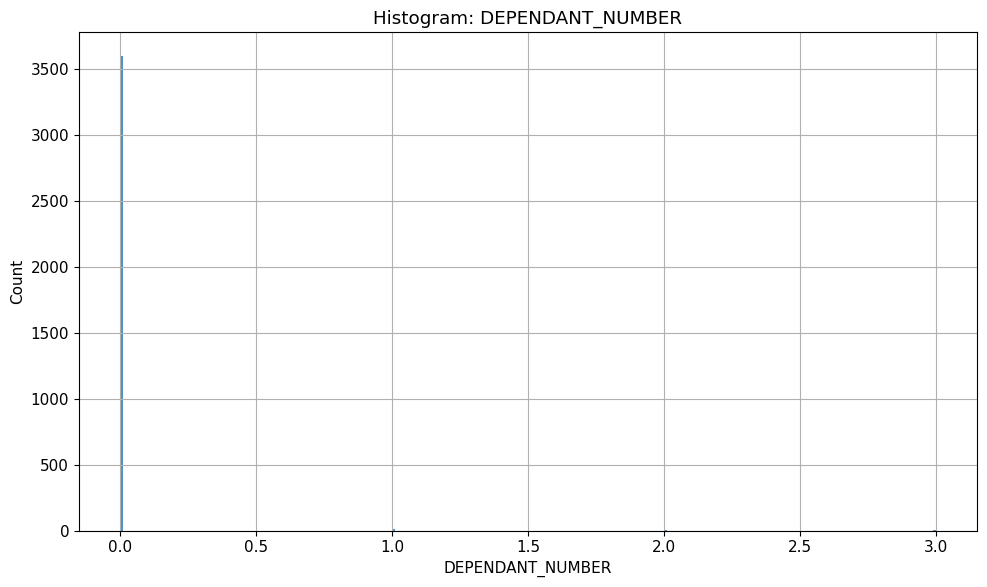

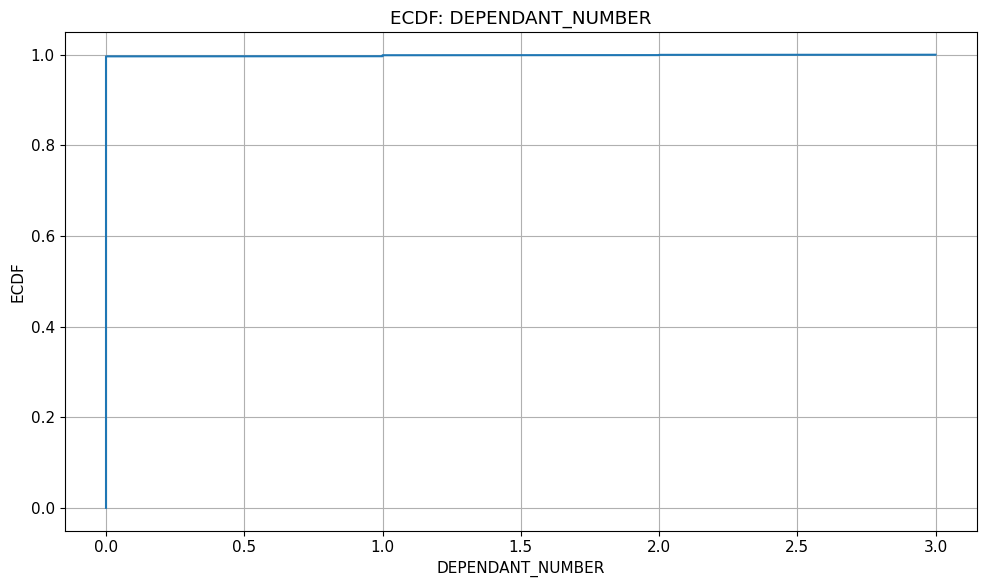

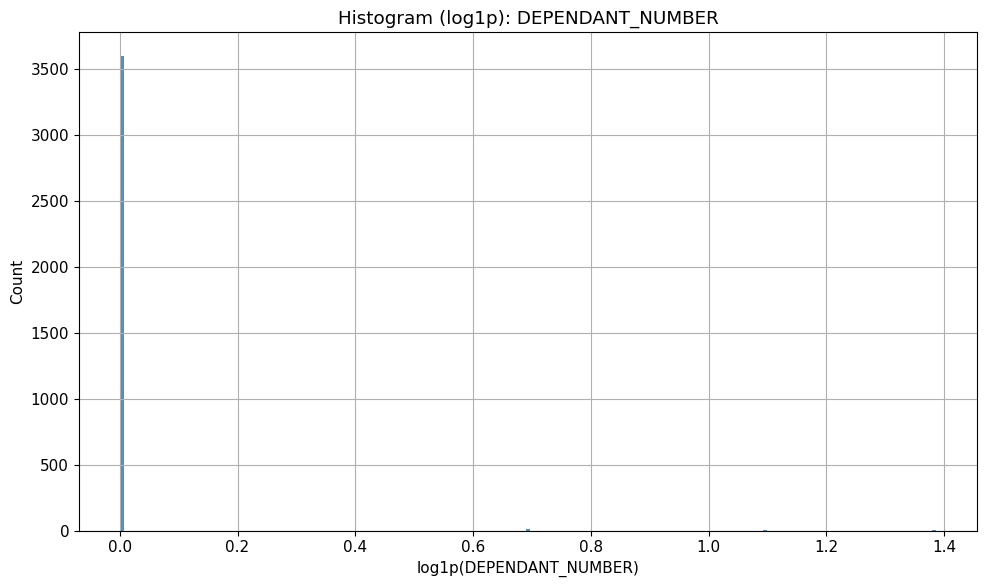

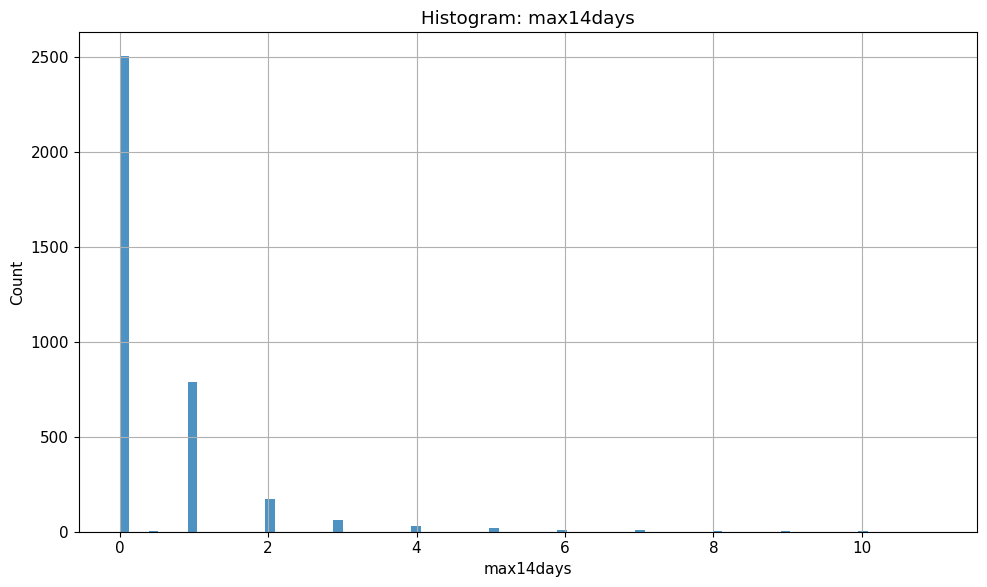

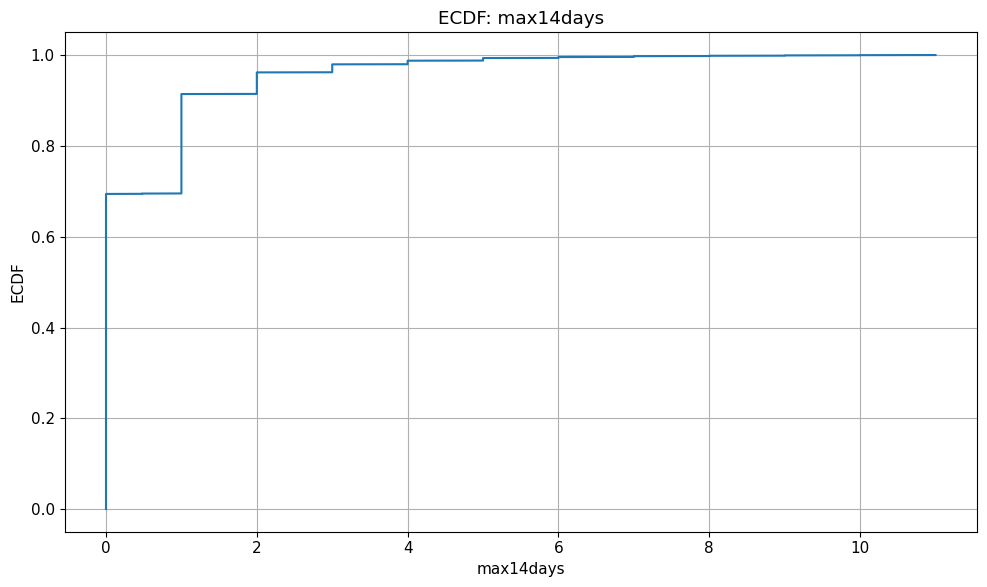

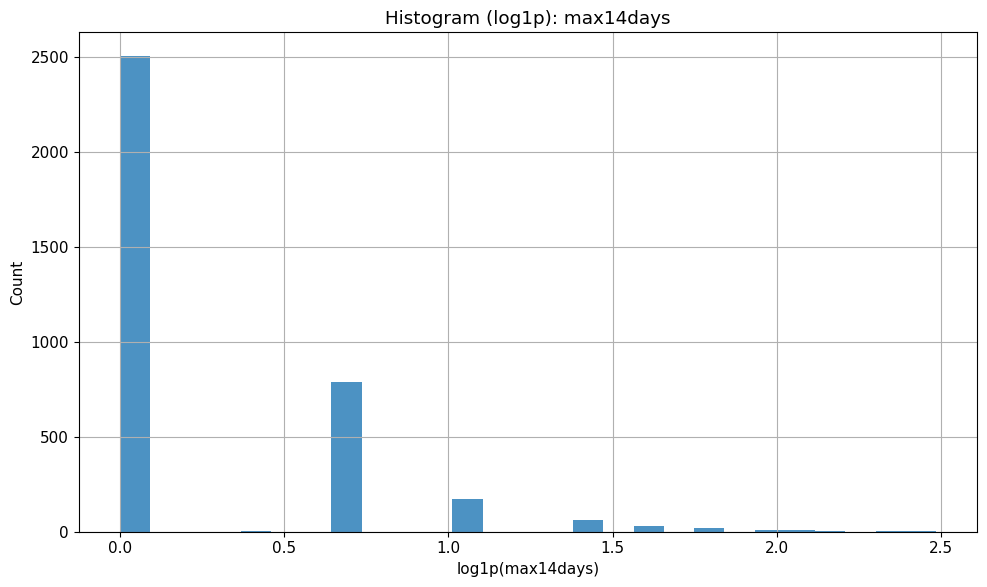

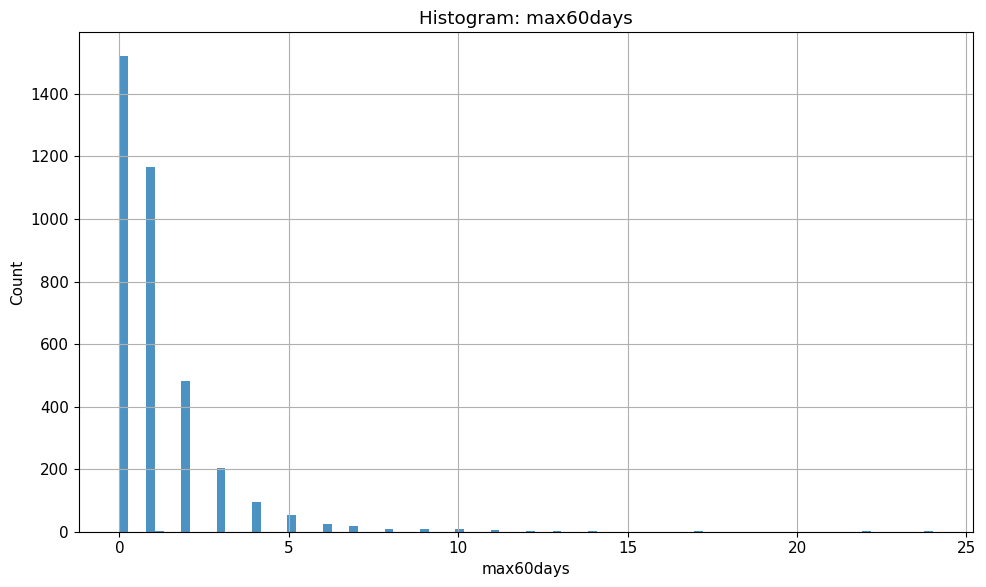

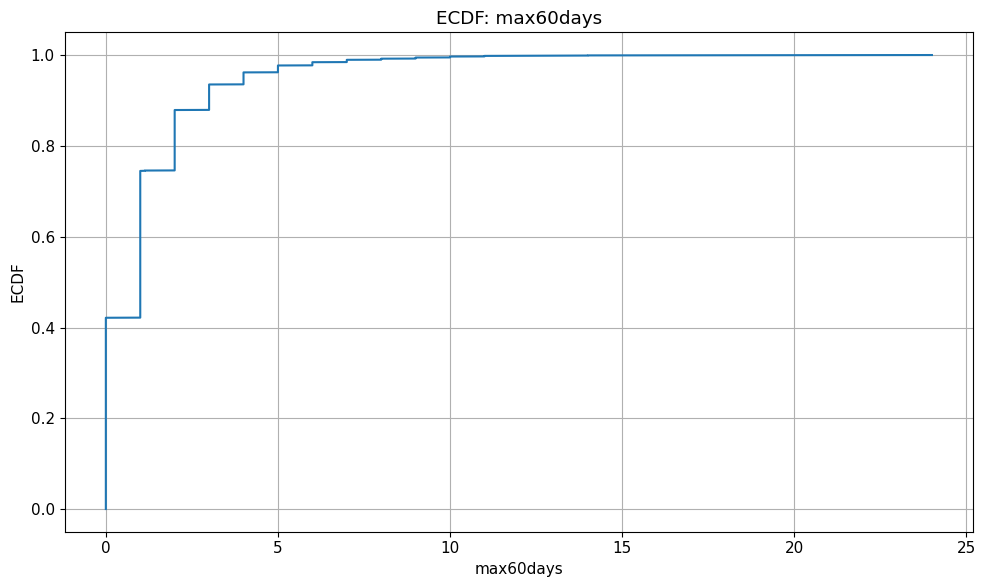

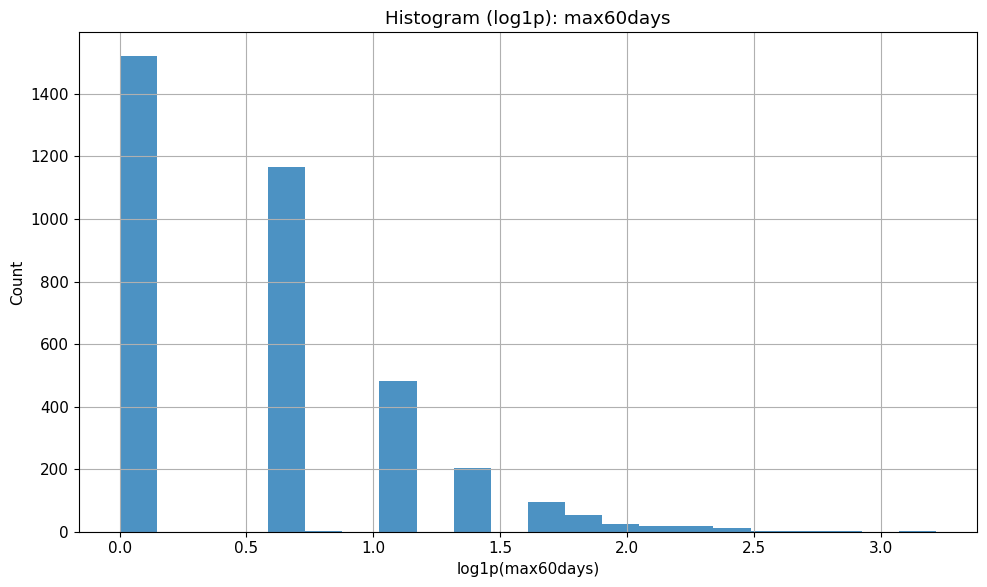

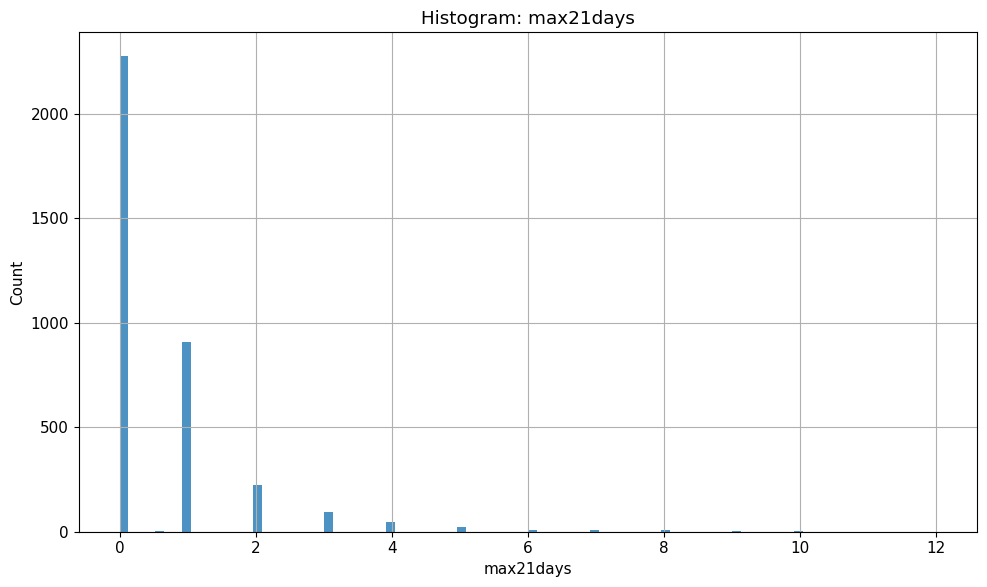

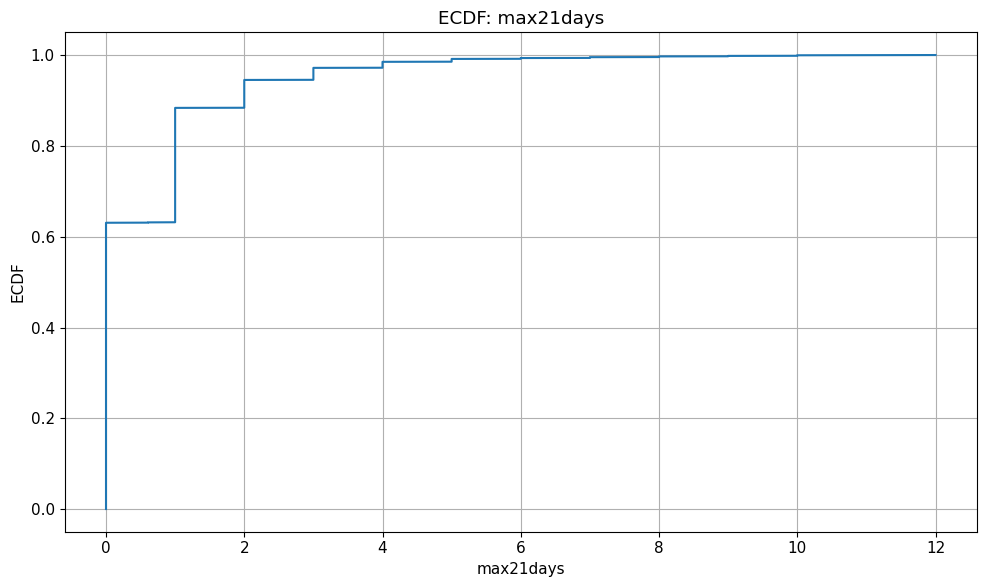

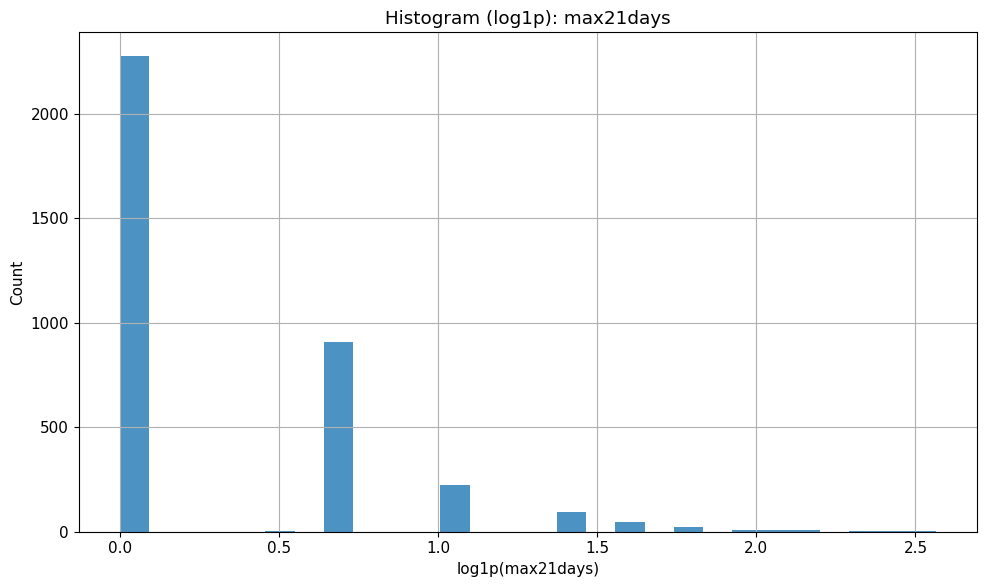

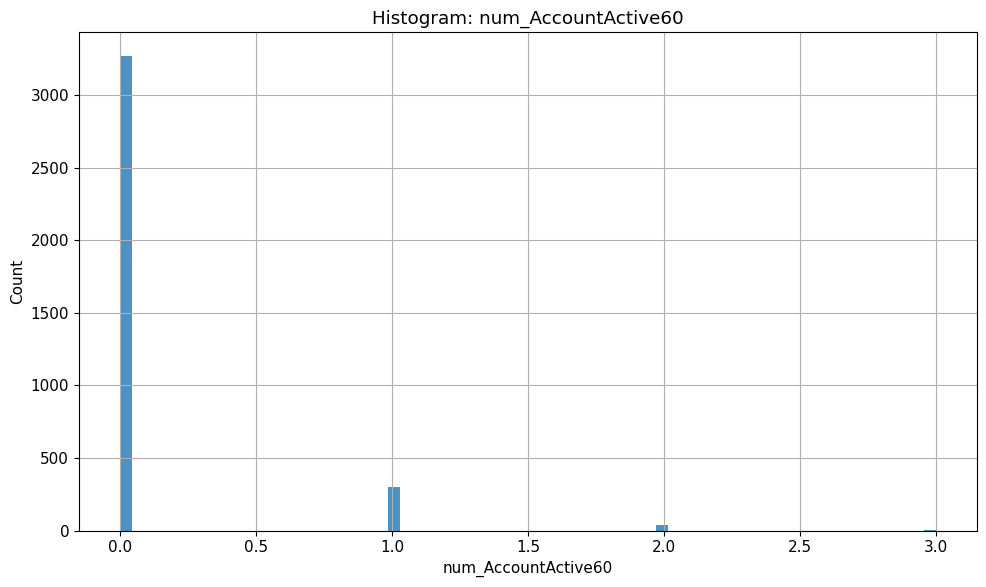

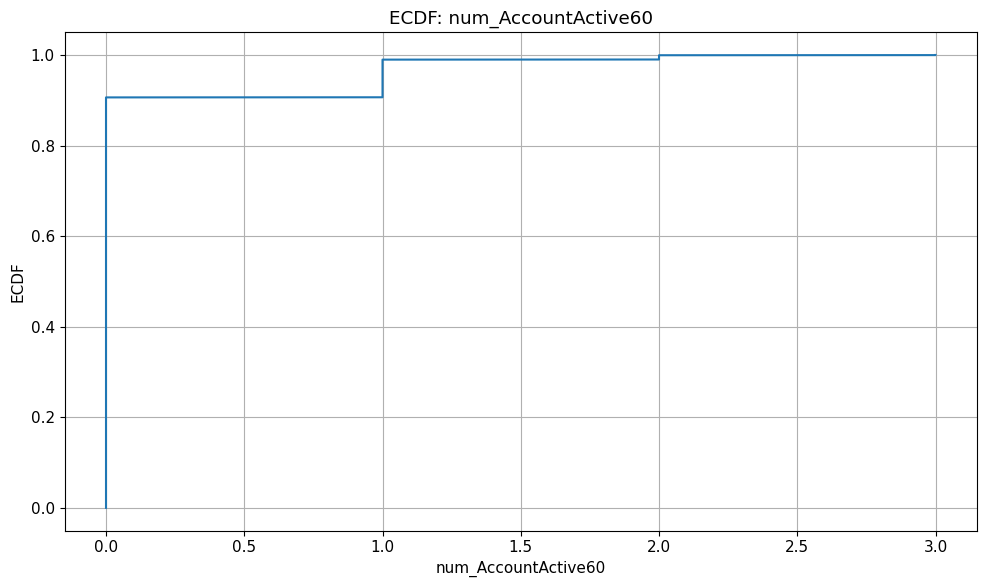

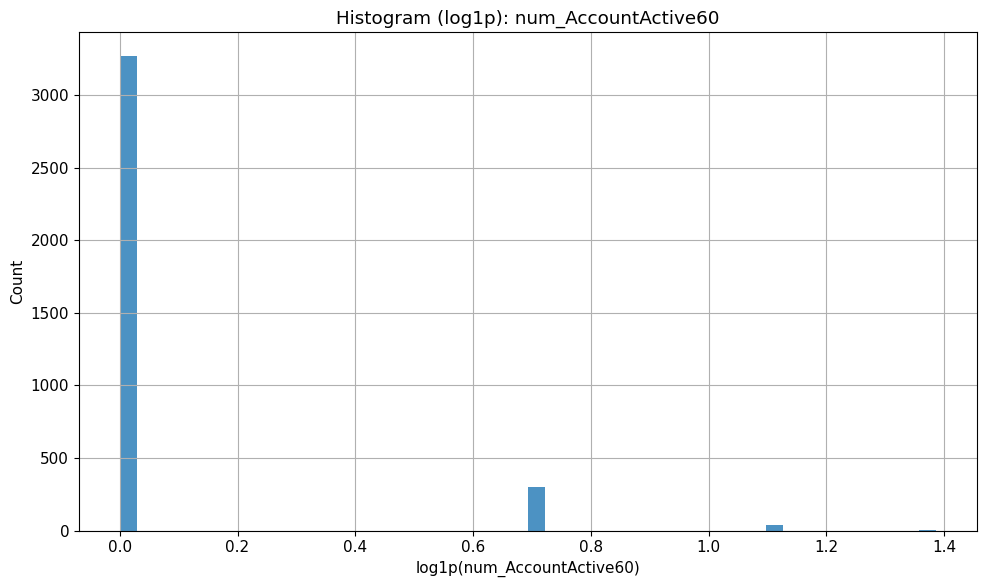

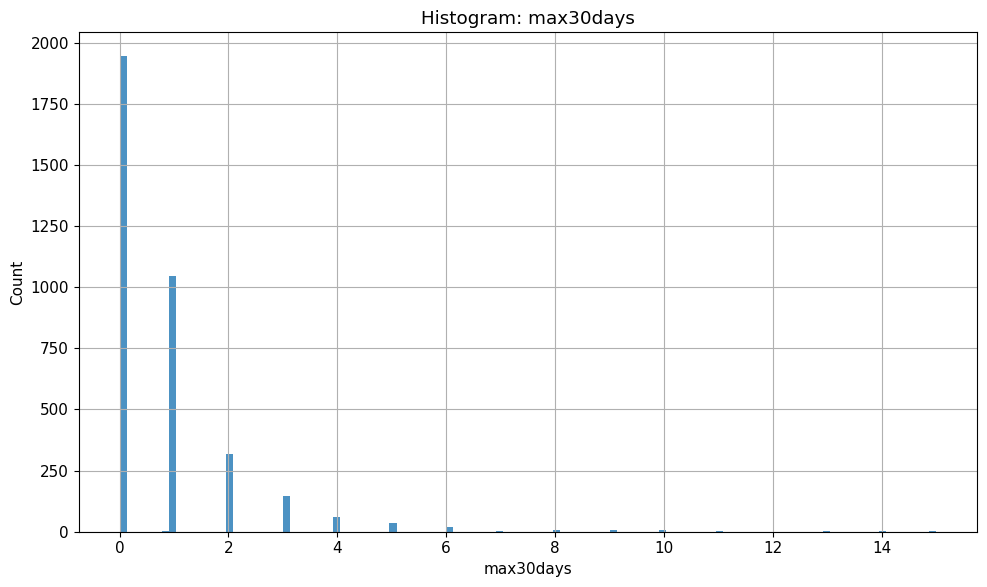

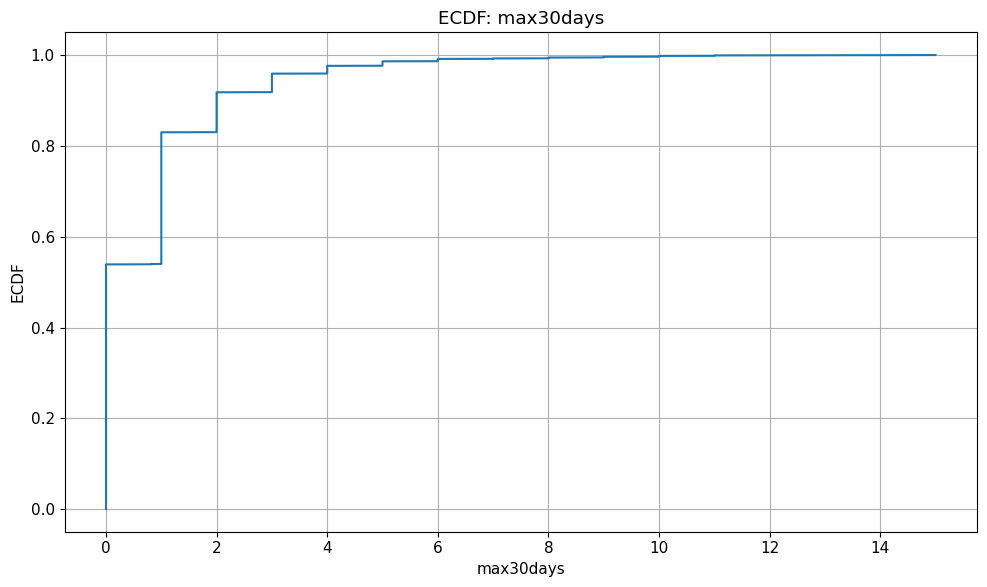

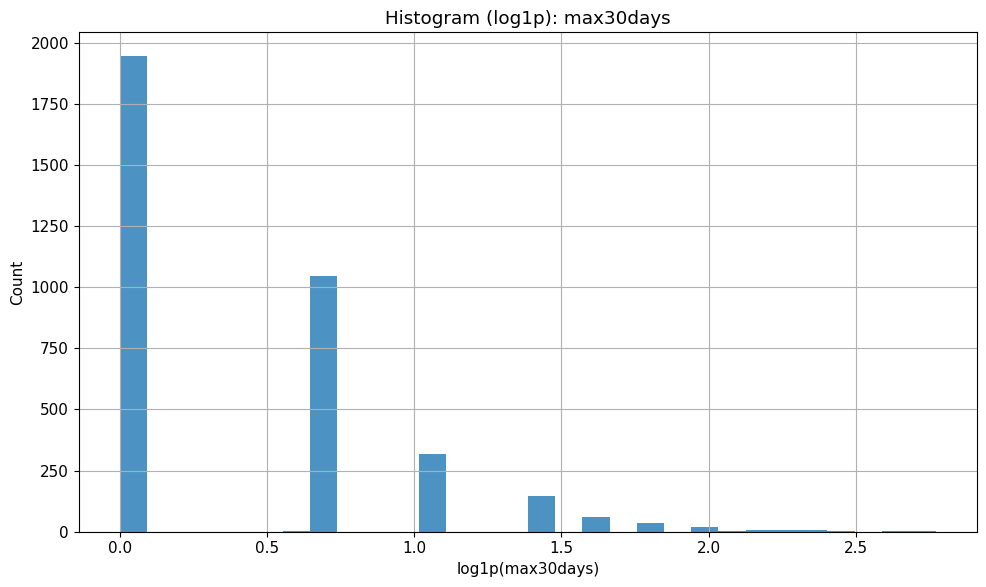

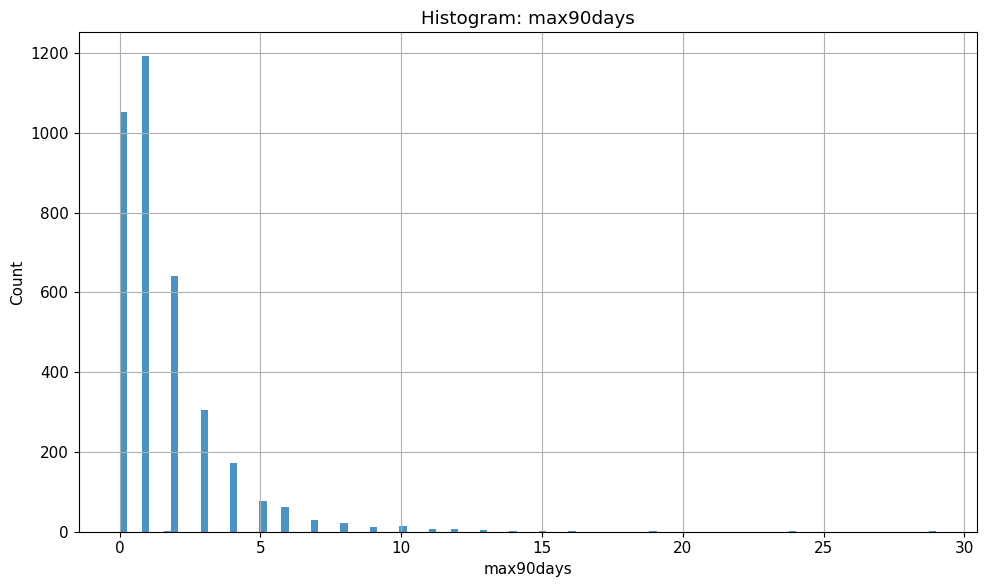

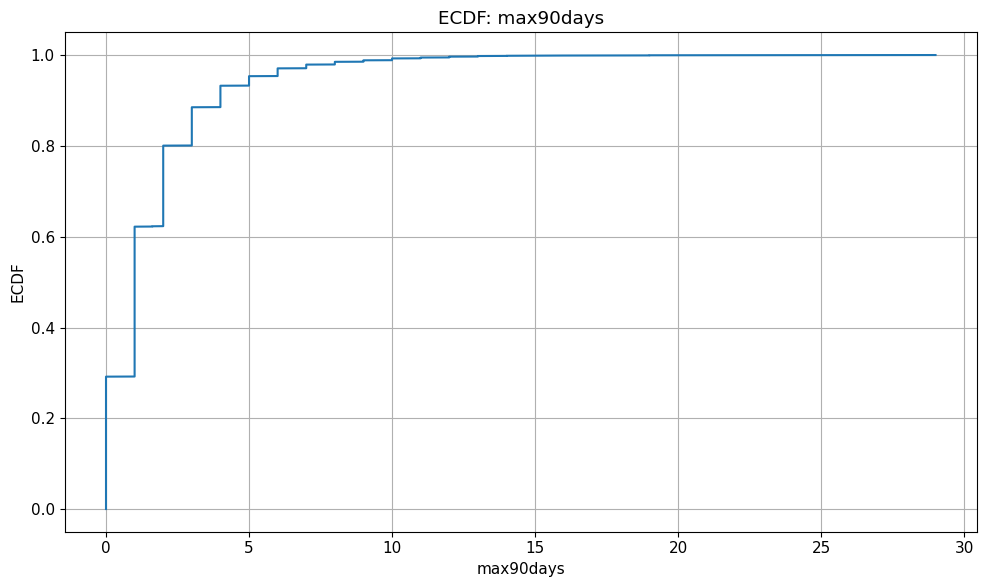

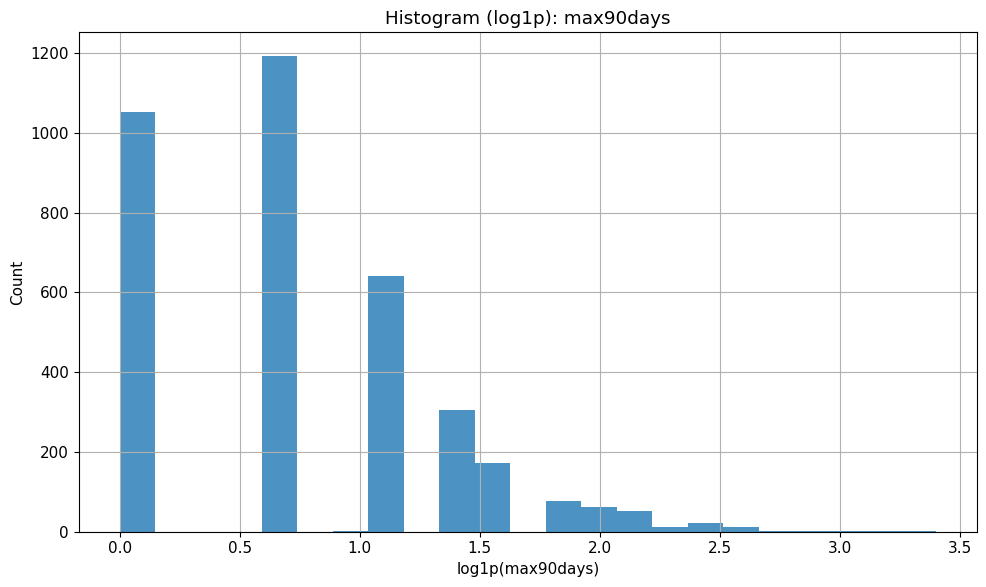

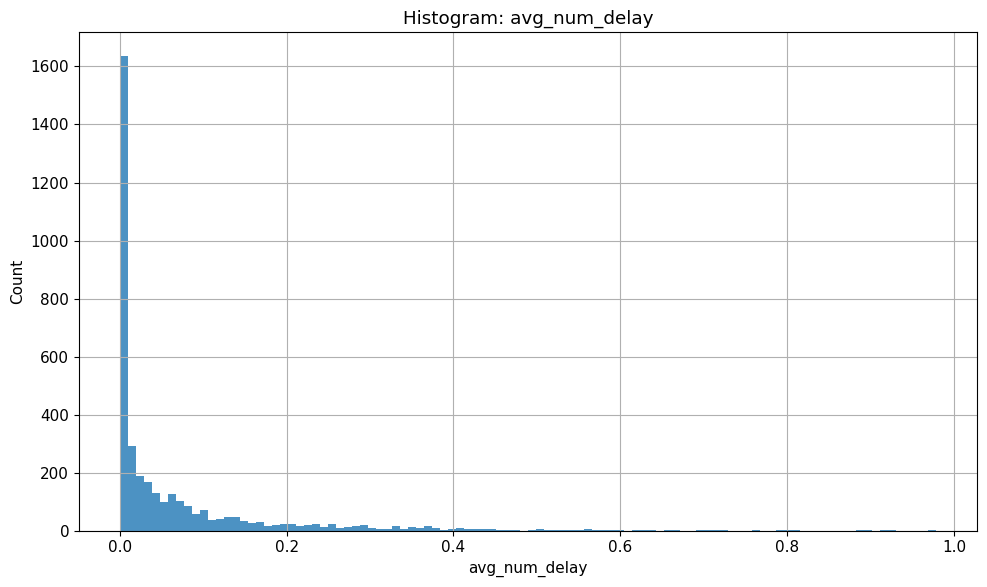

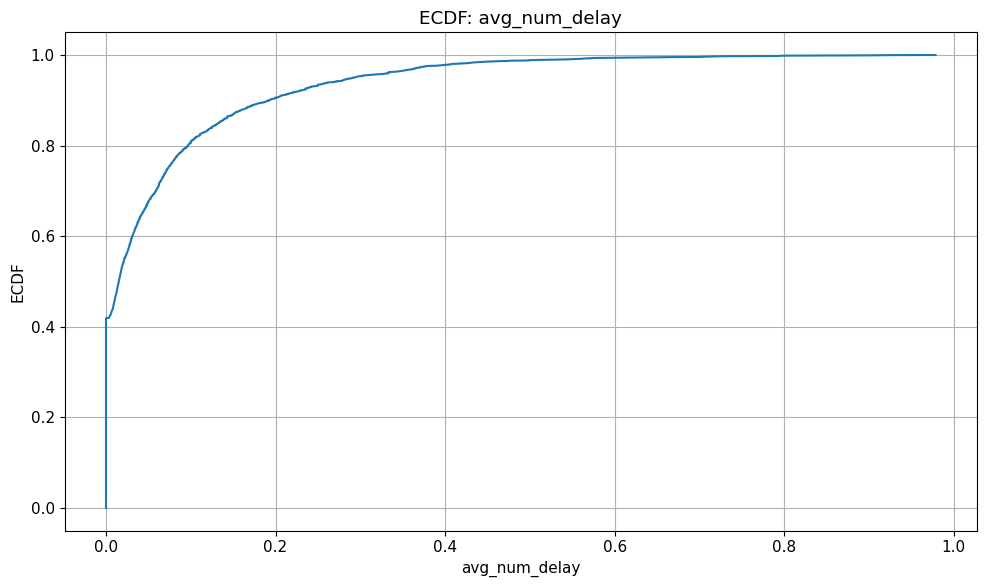

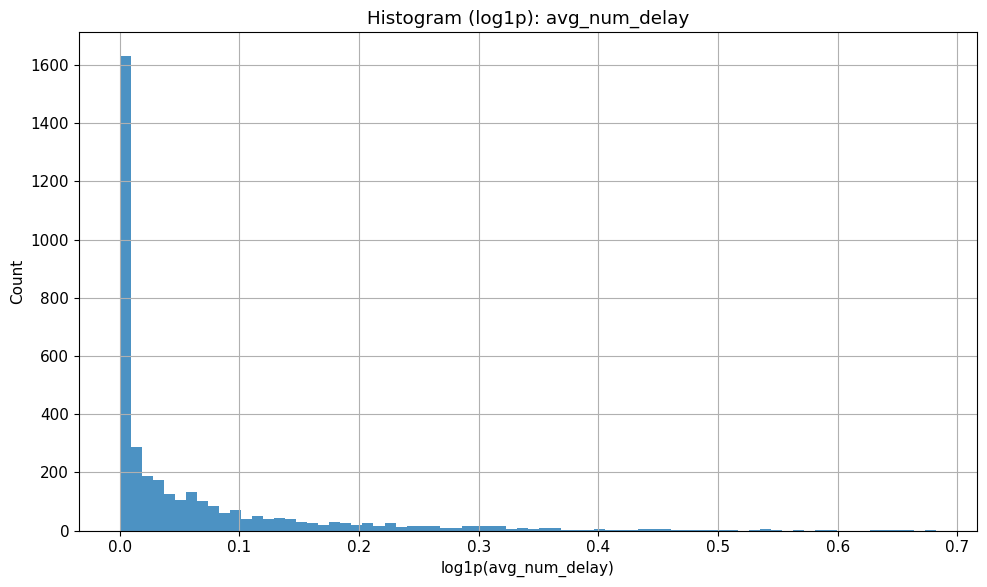

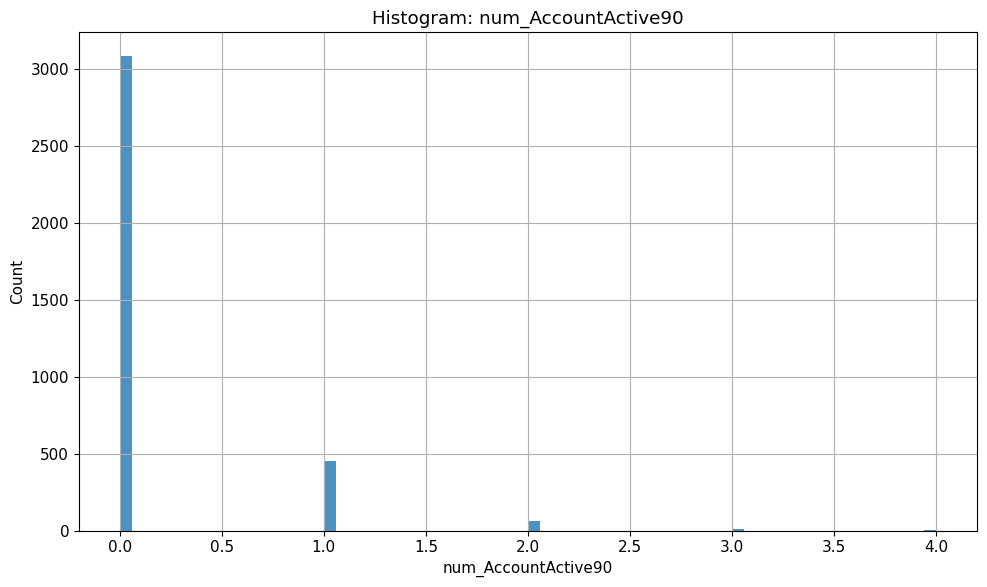

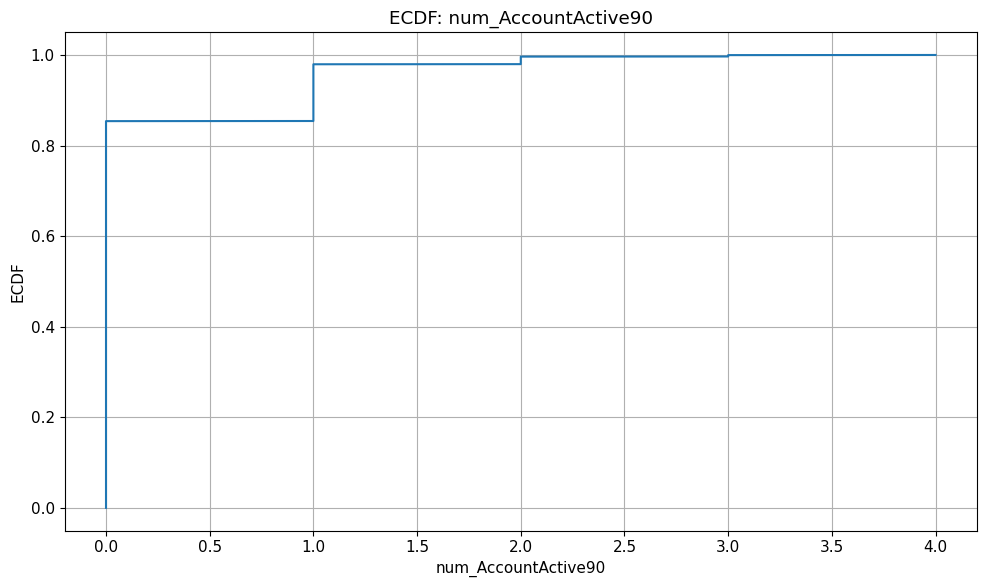

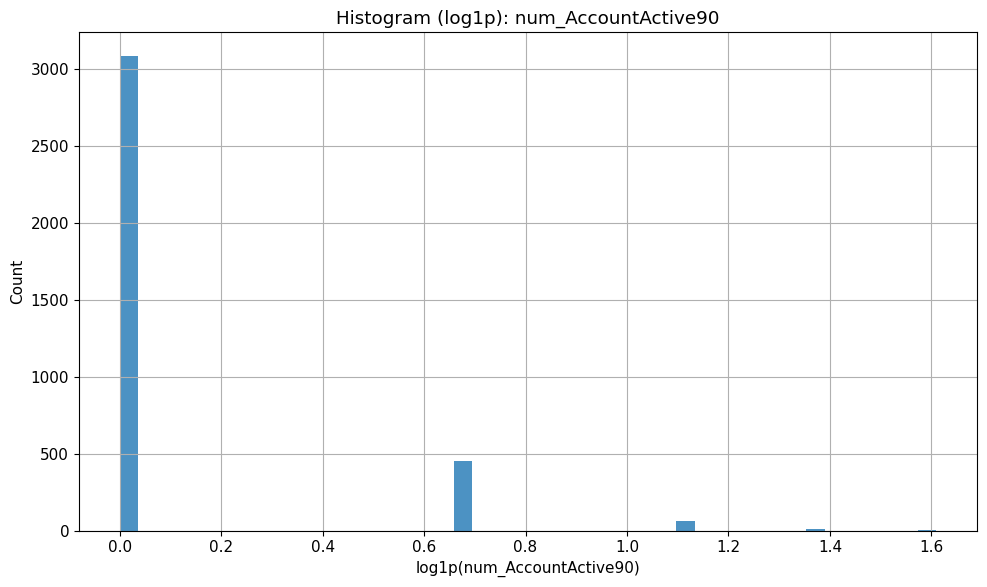

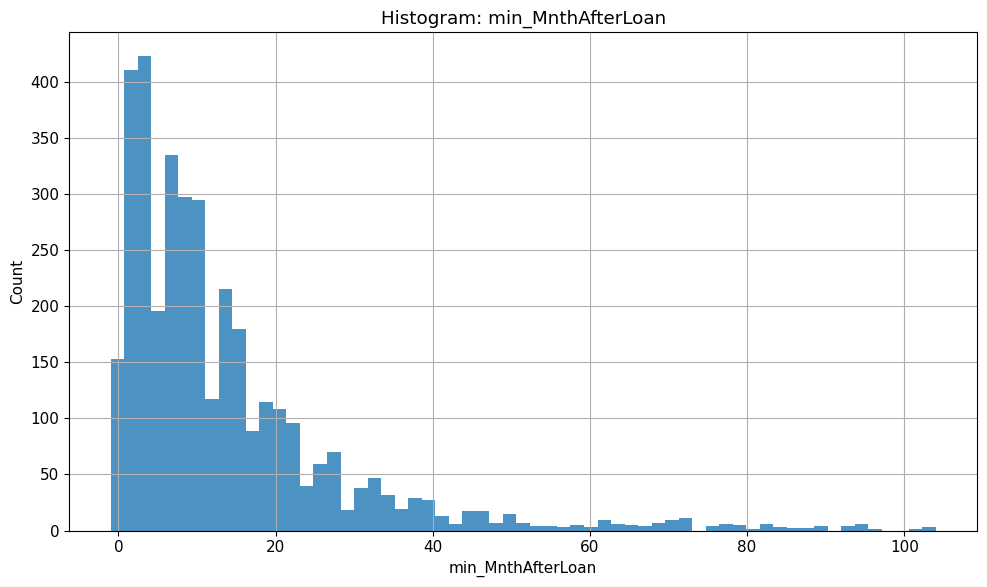

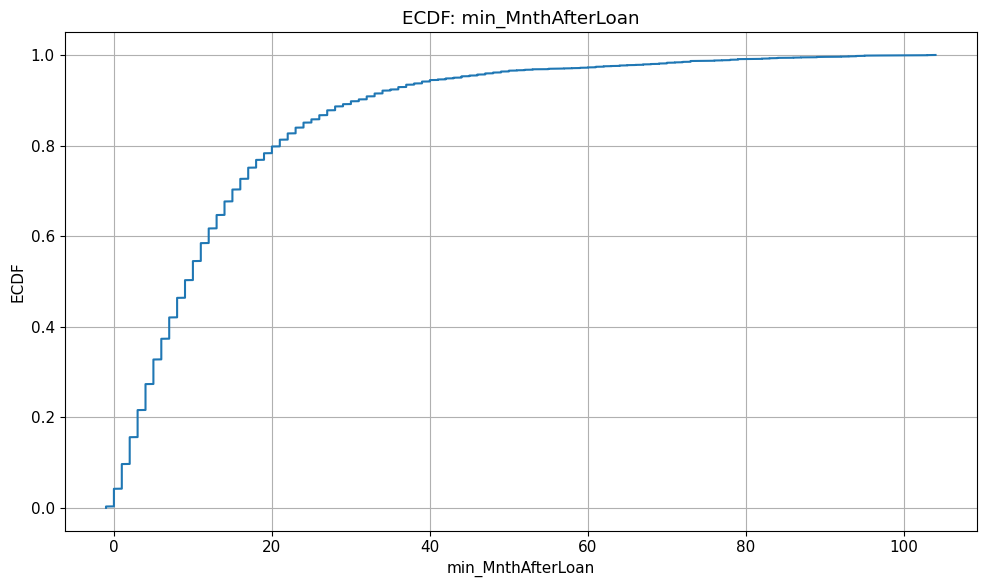

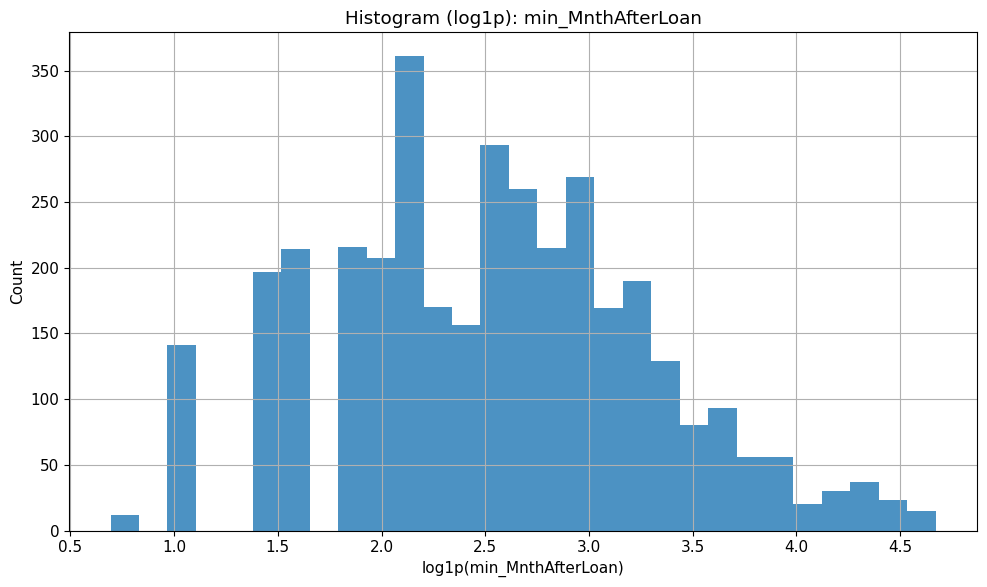

In [25]:
summary = df[num_cols].describe().T
summary['skew'] = df[num_cols].skew()
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1
outlier_mask = (df[num_cols] < (Q1 - 1.5*IQR)) | (df[num_cols] > (Q3 + 1.5*IQR))
summary['outliers'] = outlier_mask.sum()
display(summary.sort_values('outliers', ascending=False))

def ecdf(x):
    x = np.sort(np.asarray(x))
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

top_skew = summary['skew'].abs().sort_values(ascending=False).head(min(10, len(summary))).index
for c in top_skew:
    x = df[c].dropna().values
    if len(x) == 0:
        continue
    q25, q75 = np.percentile(x, [25, 75])
    iqr = q75 - q25 if q75>q25 else (np.std(x) if np.std(x)>0 else 1.0)
    bin_width = 2 * iqr / (len(x) ** (1/3)) if len(x)>0 else 1.0
    bins = max(10, int((x.max()-x.min())/bin_width)) if bin_width>0 else 30

    plt.figure(); plt.hist(x, bins=bins, alpha=0.8)
    plt.title(f'Histogram: {c}'); plt.xlabel(c); plt.ylabel('Count'); plt.tight_layout(); plt.show()

    xs, ys = ecdf(x)
    plt.figure(); plt.plot(xs, ys)
    plt.title(f'ECDF: {c}'); plt.xlabel(c); plt.ylabel('ECDF'); plt.tight_layout(); plt.show()

    if summary.loc[c, 'skew'] > 1.0:
        xl = np.log1p(x - x.min() + 1) if (x<0).any() else np.log1p(x)
        q25l, q75l = np.percentile(xl, [25, 75])
        iqr_l = q75l - q25l if q75l>q25l else (np.std(xl) if np.std(xl)>0 else 1.0)
        bin_width_l = 2 * iqr_l / (len(xl) ** (1/3)) if len(xl)>0 else 1.0
        bins_l = max(10, int((xl.max()-xl.min())/bin_width_l)) if bin_width_l>0 else 30
        plt.figure(); plt.hist(xl, bins=bins_l, alpha=0.8)
        plt.title(f'Histogram (log1p): {c}'); plt.xlabel(f'log1p({c})'); plt.ylabel('Count'); plt.tight_layout(); plt.show()

### 5. Categorical distributions

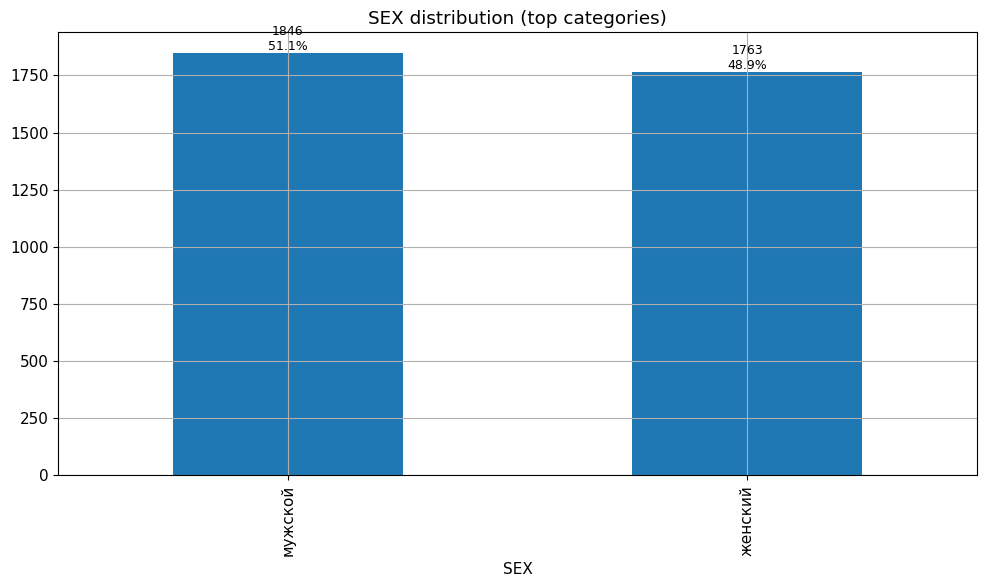

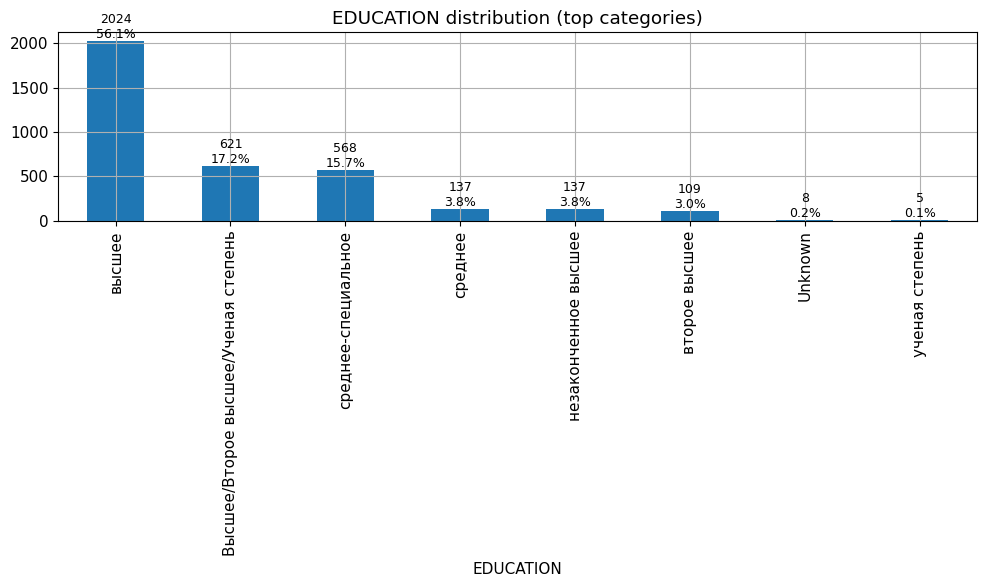

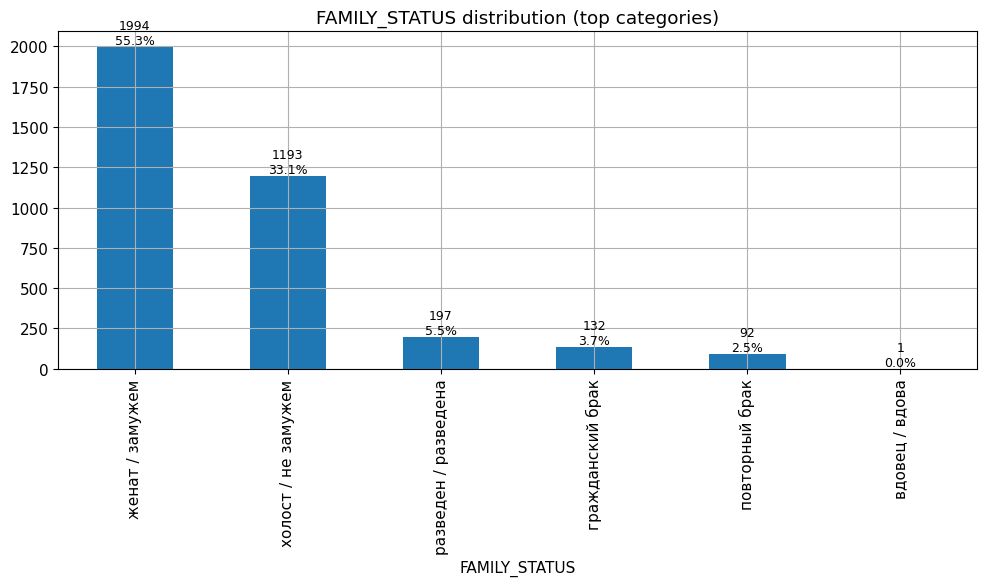

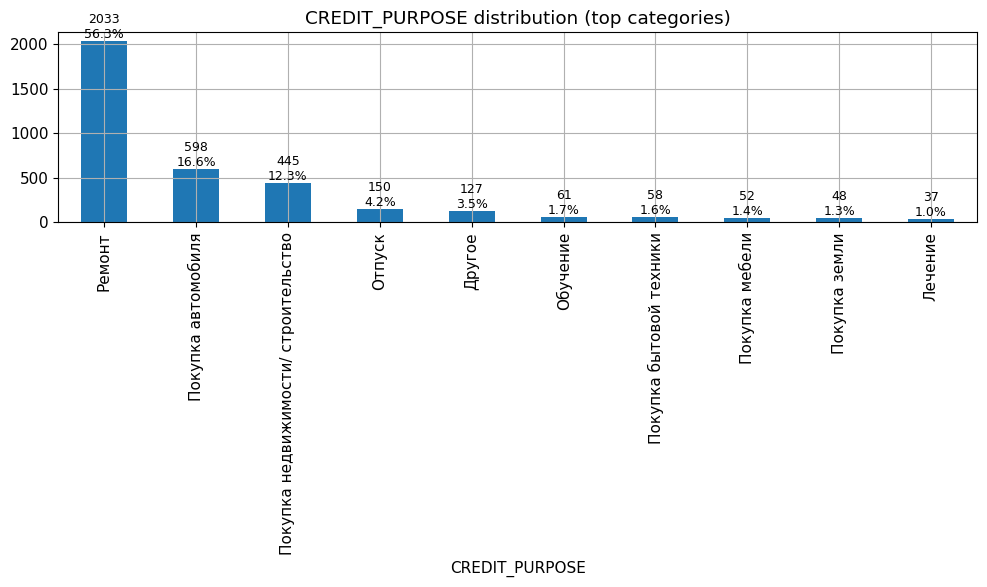

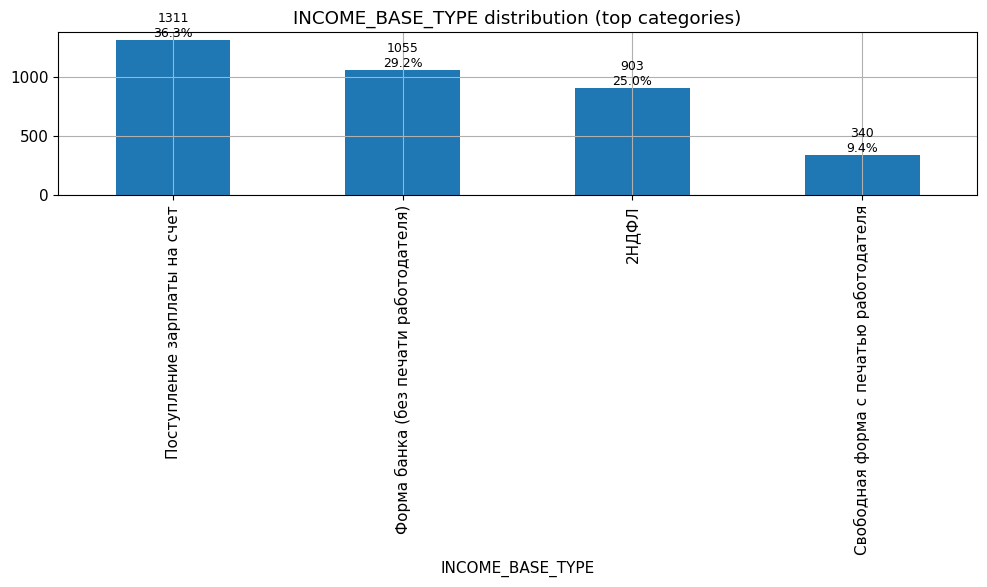

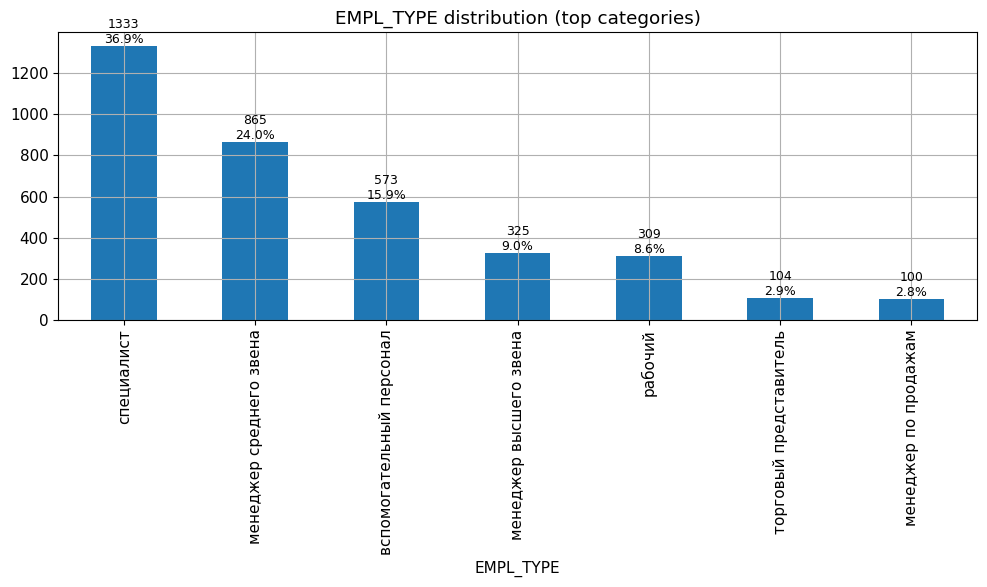

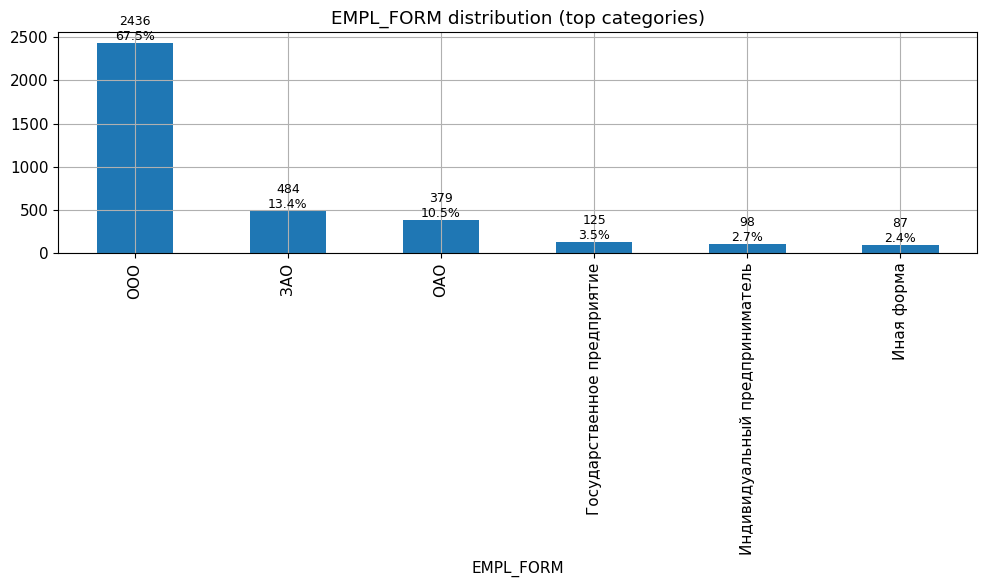

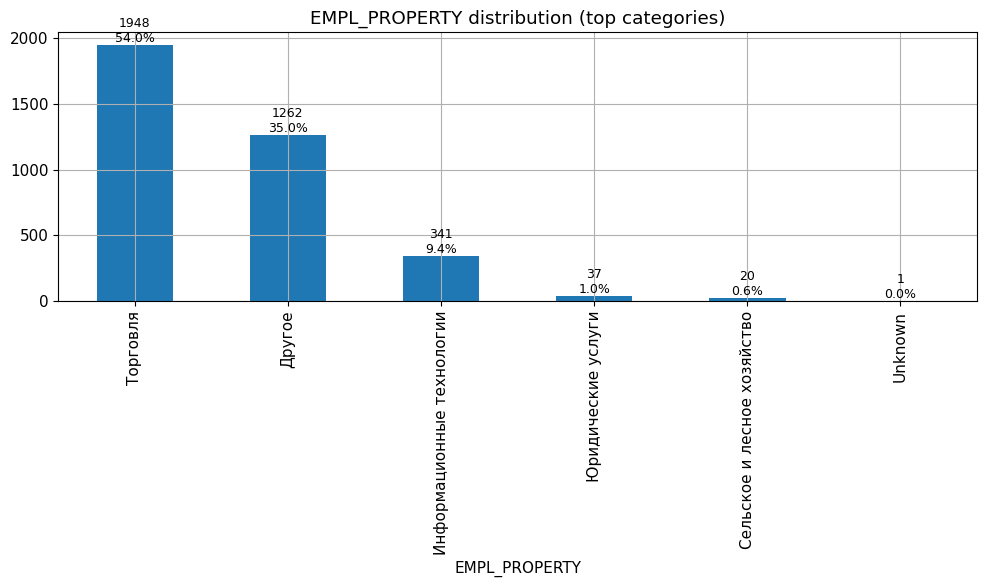

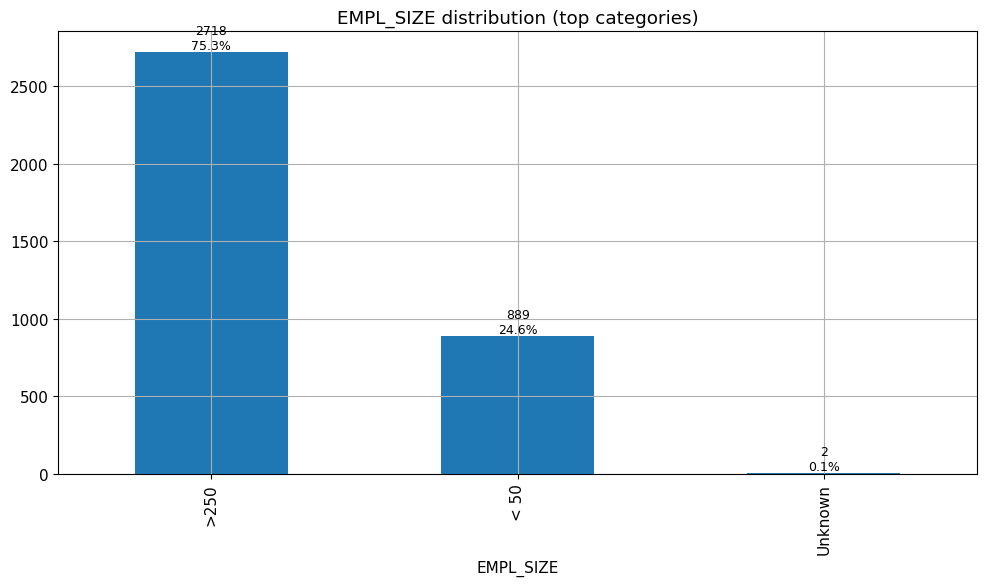

In [26]:
def bar_with_labels(series, title, topn=20):
    vc = series.value_counts(dropna=False)
    vc = vc.head(min(topn, len(vc)))
    total = vc.sum()
    plt.figure()
    vc.plot(kind='bar')
    for i, (name, val) in enumerate(vc.items()):
        pct = 100.0*val/total if total>0 else 0
        plt.text(i, val, f'{val}\n{pct:.1f}%', ha='center', va='bottom', fontsize=9)
    plt.title(title); plt.tight_layout(); plt.show()

sel_cats = [c for c in ['SEX','EDUCATION','FAMILY_STATUS','CREDIT_PURPOSE','INCOME_BASE_TYPE','EMPL_TYPE','EMPL_FORM','EMPL_PROPERTY','EMPL_SIZE'] if c in df.columns]
for c in sel_cats:
    bar_with_labels(df[c], f'{c} distribution (top categories)')

### 6. Correlations

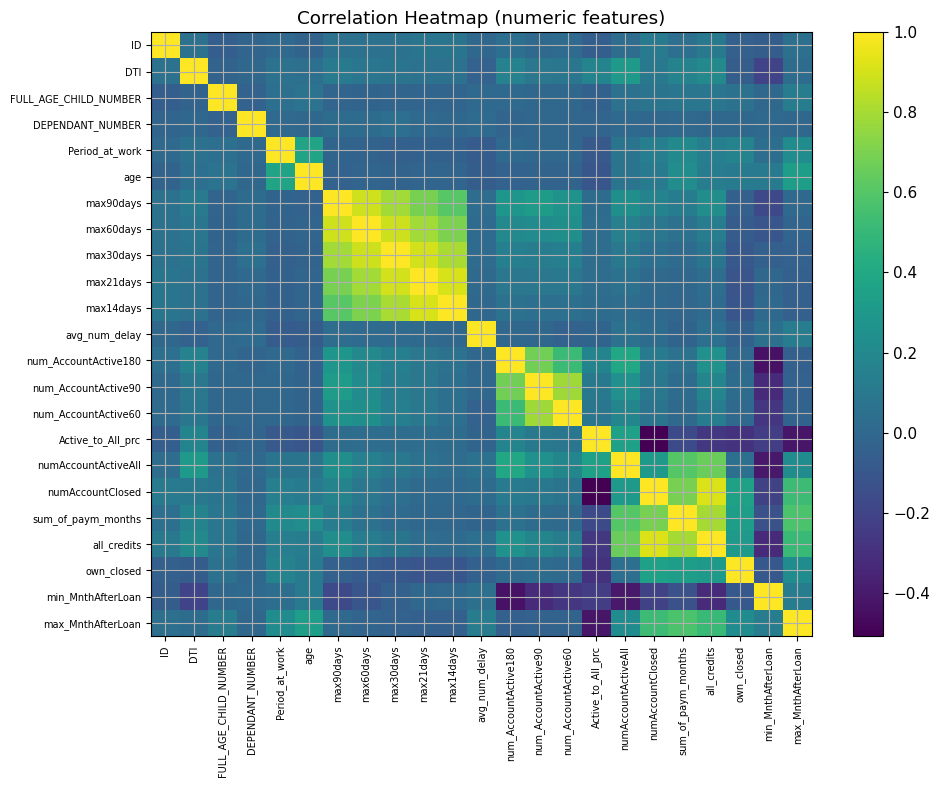

,var1,var2,corr
0,numAccountClosed,all_credits,0.921958
1,max21days,max14days,0.907310
2,max30days,max21days,0.895245
3,max90days,max60days,0.889076
4,max60days,max30days,0.886028
5,max30days,max14days,0.810366
6,sum_of_paym_months,all_credits,0.795968
7,max60days,max21days,0.792669
8,max90days,max30days,0.788311
9,num_AccountActive90,num_AccountActive60,0.787580


In [27]:
num_for_corr = [c for c in num_cols if df[c].nunique()>1]
if len(num_for_corr) >= 2:
    corr = df[num_for_corr].corr(numeric_only=True)
    plt.figure(figsize=(10,8))
    plt.imshow(corr, interpolation='nearest', aspect='auto')
    plt.colorbar()
    plt.title('Correlation Heatmap (numeric features)')
    plt.xticks(range(len(num_for_corr)), num_for_corr, rotation=90, fontsize=7)
    plt.yticks(range(len(num_for_corr)), num_for_corr, fontsize=7)
    plt.tight_layout(); plt.show()

    tri = []
    for i in range(len(num_for_corr)):
        for j in range(i+1, len(num_for_corr)):
            tri.append((num_for_corr[i], num_for_corr[j], corr.iloc[i,j]))
    tri_sorted = sorted(tri, key=lambda t: abs(t[2]), reverse=True)[:20]
    strongest = pd.DataFrame(tri_sorted, columns=['var1','var2','corr'])
    display(strongest)
else:
    print("Not enough numeric columns for correlation heatmap.")

### 7. Final vitrine

In [28]:
# SAFE vitrine creation (no duplicate insert; aligned IDs)
vitrine = df.copy()

# decide ID column name
id_col = ID_COL if ('ID_COL' in globals() and ID_COL) else 'ID'

# get ID values aligned to current index
import pandas as pd
import numpy as np

if 'id_series' in globals() and isinstance(id_series, pd.Series):
    # выровнять по индексу после дропов/фильтров
    try:
        ids = id_series.reindex(vitrine.index)
    except Exception:
        ids = pd.Series(np.arange(1, len(vitrine)+1), index=vitrine.index, name=id_col)
else:
    # если уже есть ID — используем; иначе создаём новый
    if id_col in vitrine.columns:
        ids = vitrine[id_col]
    else:
        ids = pd.Series(np.arange(1, len(vitrine)+1), index=vitrine.index, name=id_col)

# добавить/обновить столбец без insert-конфликта
if id_col in vitrine.columns:
    vitrine[id_col] = ids.values
else:
    vitrine.insert(0, id_col, ids.values)

print("Vitrine shape:", vitrine.shape)
display(vitrine.head(5))

vitrine_path = 'vitrine_clean.csv'
vitrine.to_csv(vitrine_path, index=False)
print("Saved:", vitrine_path)


Vitrine shape: (3609, 44)


,Номер варианта,ID,INCOME_BASE_TYPE,CREDIT_PURPOSE,INSURANCE_FLAG,DTI,SEX,FULL_AGE_CHILD_NUMBER,DEPENDANT_NUMBER,EDUCATION,...,own_closed,min_MnthAfterLoan,max_MnthAfterLoan,dlq_exist,thirty_in_a_year,sixty_in_a_year,ninety_in_a_year,thirty_vintage,sixty_vintage,ninety_vintage
3,20,1000080,Поступление зарплаты на счет,Ремонт,1,0.59,женский,1,0,Высшее/Второе высшее/Ученая степень,...,0.0,5.0,72.0,1,0,0,0,1,0,0
4,20,1000100,2НДФЛ,Ремонт,1,0.58,женский,0,0,высшее,...,0.0,1.0,89.0,1,1,0,0,0,0,0
8,20,1000180,Форма банка (без печати работодателя),Ремонт,1,0.18,женский,0,0,среднее-специальное,...,2.0,4.0,12.0,1,0,0,0,0,0,0
13,20,1000280,Форма банка (без печати работодателя),Ремонт,0,0.39,женский,0,0,высшее,...,0.0,12.0,19.0,0,0,0,0,0,0,0
20,20,1000420,Поступление зарплаты на счет,Покупка автомобиля,0,0.14,женский,1,0,высшее,...,0.0,1.0,71.0,0,0,0,0,0,0,0


Saved: vitrine_clean.csv


## Part 2 — Segmentation

### A. KMeans with PCA, metrics & t-SNE

Transformed shape: (3609, 86)
PCA components reaching 90%+ variance: 28


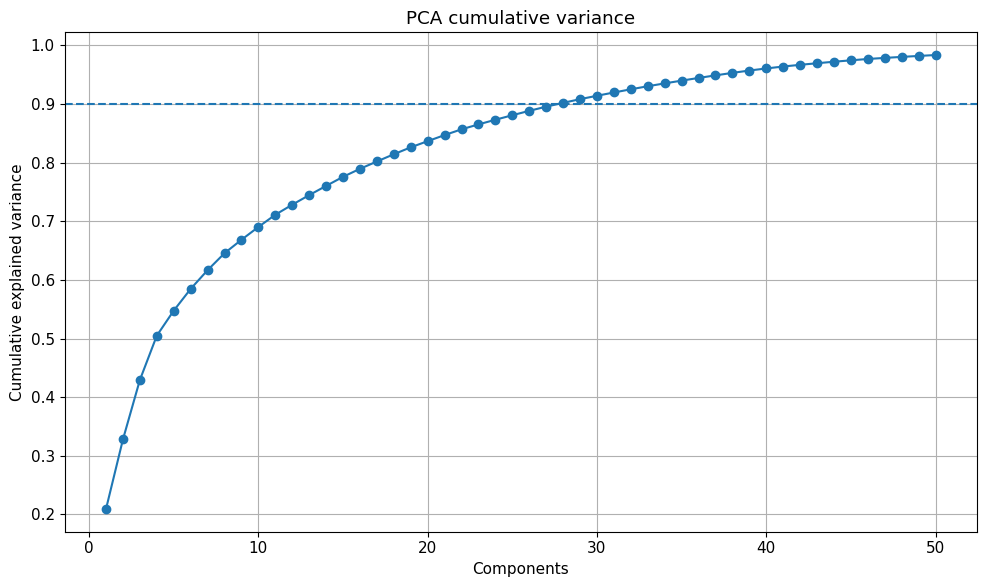

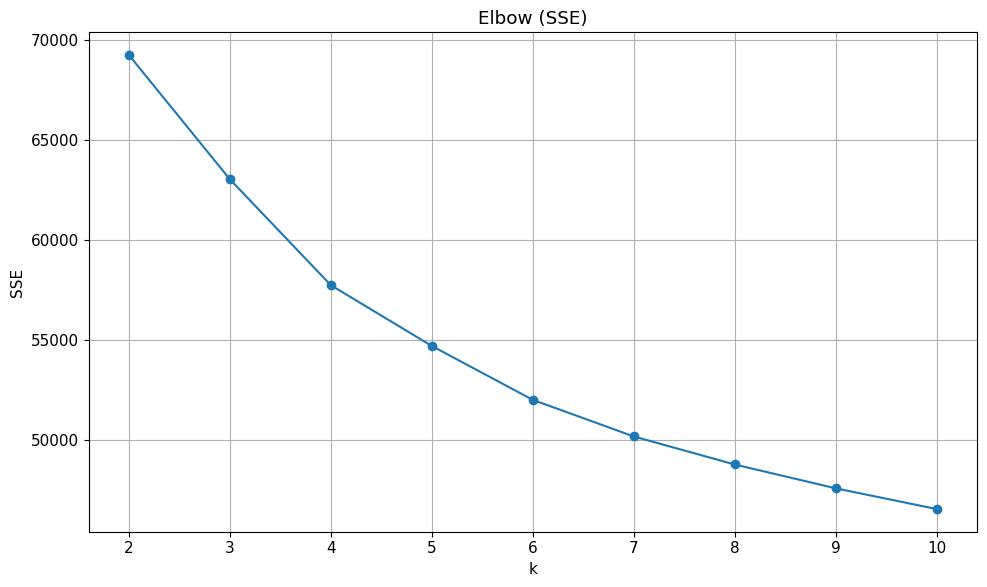

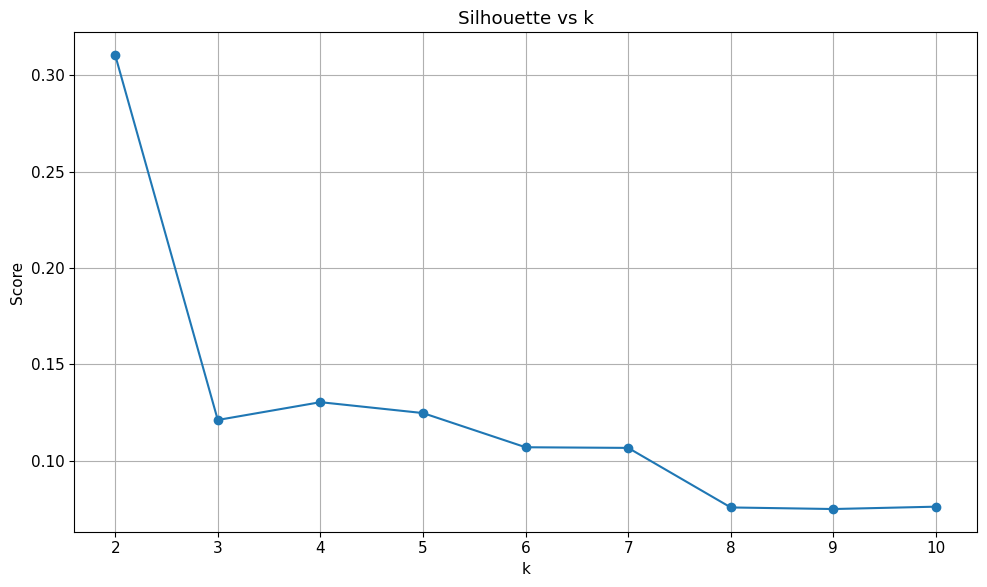

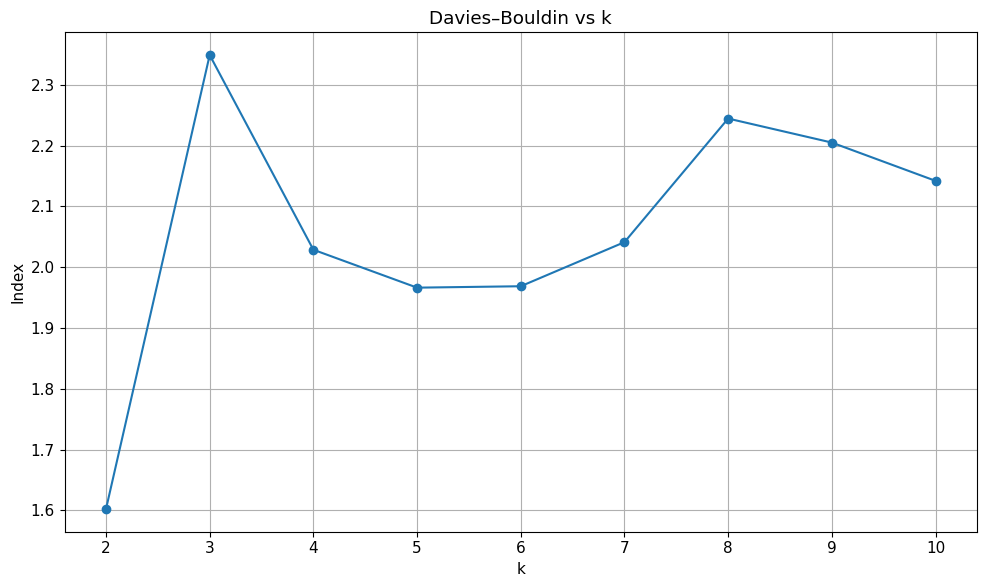

Chosen K (heuristic): 3
Cluster sizes: {0: 2065, 1: 249, 2: 1295}


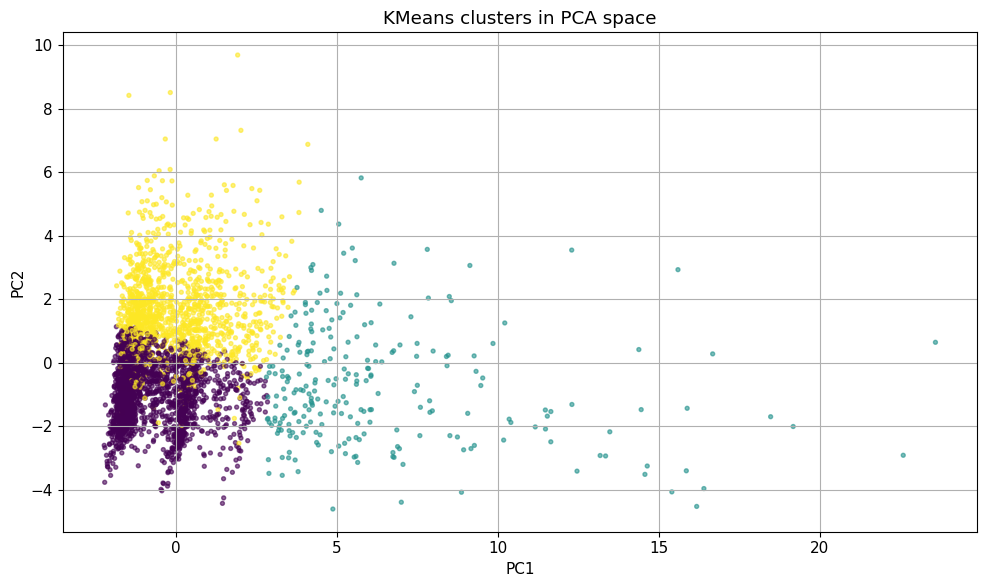

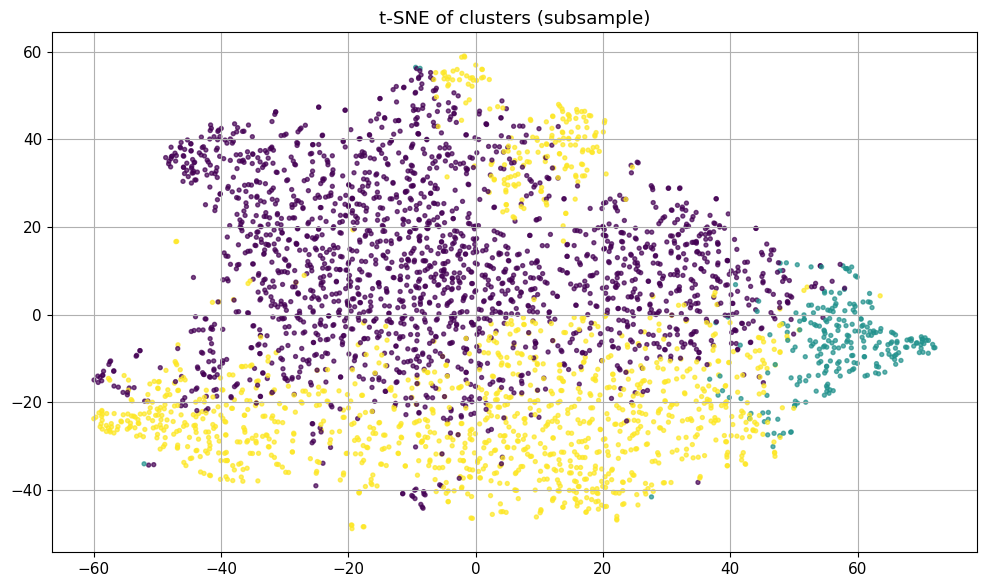

In [29]:
id_col = ID_COL if ID_COL else 'ID'
X = vitrine.drop(columns=[id_col], errors='ignore')
num_cols_km = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_cols_km = [c for c in X.columns if c not in num_cols_km]

try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

pre = ColumnTransformer([('num', RobustScaler(), num_cols_km),
                         ('cat', ohe, cat_cols_km)])
Xp = pre.fit_transform(X)
print("Transformed shape:", Xp.shape)

pca = PCA(n_components=min(50, Xp.shape[1]))
Xp_pca = pca.fit_transform(Xp)
cum = np.cumsum(pca.explained_variance_ratio_)
k_pcs = int(np.argmax(cum >= 0.90) + 1)
Xp_pca_k = Xp_pca[:, :k_pcs]
print("PCA components reaching 90%+ variance:", k_pcs)

plt.figure(); plt.plot(np.arange(1,len(cum)+1), cum, marker='o'); plt.axhline(0.9, linestyle='--')
plt.xlabel('Components'); plt.ylabel('Cumulative explained variance'); plt.title('PCA cumulative variance'); plt.tight_layout(); plt.show()

ks = list(range(2, 11))
sse, sil, db = [], [], []
for k in ks:
    km_tmp = KMeans(n_clusters=k, n_init=25, random_state=SEED)
    labels_tmp = km_tmp.fit_predict(Xp_pca_k)
    sse.append(km_tmp.inertia_)
    sil.append(silhouette_score(Xp_pca_k, labels_tmp))
    db.append(davies_bouldin_score(Xp_pca_k, labels_tmp))

plt.figure(); plt.plot(ks, sse, marker='o'); plt.title('Elbow (SSE)'); plt.xlabel('k'); plt.ylabel('SSE'); plt.tight_layout(); plt.show()
plt.figure(); plt.plot(ks, sil, marker='o'); plt.title('Silhouette vs k'); plt.xlabel('k'); plt.ylabel('Score'); plt.tight_layout(); plt.show()
plt.figure(); plt.plot(ks, db, marker='o'); plt.title('Davies–Bouldin vs k'); plt.xlabel('k'); plt.ylabel('Index'); plt.tight_layout(); plt.show()

scores = []
for i, k in enumerate(ks):
    s_norm = (sil[i] - min(sil)) / (max(sil) - min(sil) + 1e-9)
    db_norm = (max(db) - db[i]) / (max(db) - min(db) + 1e-9)
    grad = sse[i-1]-sse[i] if i>0 else sse[i]-sse[i+1]
    elbow = max(0.0, grad / (sse[0]-sse[-1] + 1e-9))
    scores.append(0.45*s_norm + 0.45*db_norm + 0.10*elbow)
best_k = ks[int(np.argmax(scores))]
K = max(3, min(8, best_k))
print("Chosen K (heuristic):", K)

km = KMeans(n_clusters=K, n_init=30, random_state=SEED)
labels = km.fit_predict(Xp_pca_k)
vitrine_km = vitrine.copy(); vitrine_km['cluster'] = labels
print("Cluster sizes:", vitrine_km['cluster'].value_counts().sort_index().to_dict())

plt.figure(); plt.scatter(Xp_pca_k[:,0], Xp_pca_k[:,1], c=labels, s=8, alpha=0.6)
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('KMeans clusters in PCA space'); plt.tight_layout(); plt.show()

# t-SNE (subsample)
n_vis = min(4000, Xp_pca_k.shape[0])
idx = np.random.choice(Xp_pca_k.shape[0], size=n_vis, replace=False)
tsne = TSNE(n_components=2, learning_rate='auto', init='pca', random_state=SEED, perplexity=30)
Xp_tsne = tsne.fit_transform(Xp_pca_k[idx])
plt.figure(); plt.scatter(Xp_tsne[:,0], Xp_tsne[:,1], c=labels[idx], s=8, alpha=0.7)
plt.title('t-SNE of clusters (subsample)'); plt.tight_layout(); plt.show()

In [30]:
# Cluster profiling
def profile_clusters(df_with_labels, label_col='cluster', max_cat_levels=8):
    numc = [c for c in df_with_labels.columns if pd.api.types.is_numeric_dtype(df_with_labels[c]) and c!=label_col]
    catc = [c for c in df_with_labels.columns if c not in numc + [label_col]]
    rows = []
    for k in sorted(df_with_labels[label_col].unique()):
        d = df_with_labels[df_with_labels[label_col]==k]
        row = {'cluster': int(k), 'size': len(d)}
        for c in numc:
            row[f'mean_{c}'] = d[c].mean()
            row[f'median_{c}'] = d[c].median()
        for c in catc:
            vc = d[c].value_counts()
            row[f'top_{c}'] = '; '.join([f'{ix}:{cnt}' for ix,cnt in vc.head(max_cat_levels).items()])
        rows.append(row)
    return pd.DataFrame(rows)

cluster_profile = profile_clusters(vitrine_km)
display(cluster_profile)

# Exports
vitrine_km.to_csv('clusters_kmeans.csv', index=False)
print("Saved: clusters_kmeans.csv")

,cluster,size,mean_Номер варианта,median_Номер варианта,mean_ID,median_ID,mean_INSURANCE_FLAG,median_INSURANCE_FLAG,mean_DTI,median_DTI,...,median_ninety_vintage,top_INCOME_BASE_TYPE,top_CREDIT_PURPOSE,top_SEX,top_EDUCATION,top_EMPL_TYPE,top_EMPL_SIZE,top_EMPL_PROPERTY,top_EMPL_FORM,top_FAMILY_STATUS
0,0,2065,20.0,20.0,1.093046e+06,1084700.0,0.582082,1.0,0.374674,0.39,...,0.0,Поступление зарплаты на счет:878; Форма банка ...,Ремонт:1084; Покупка автомобиля:378; Покупка н...,мужской:1056; женский:1009,высшее:1216; среднее-специальное:335; Высшее/В...,специалист:808; менеджер среднего звена:443; в...,>250:1564; < 50:500; Unknown:1,Торговля:1093; Другое:727; Информационные техн...,ООО:1427; ЗАО:263; ОАО:214; Государственное пр...,женат / замужем:1123; холост / не замужем:724;...
1,1,249,20.0,20.0,1.106123e+06,1100880.0,0.722892,1.0,0.414859,0.44,...,0.0,2НДФЛ:119; Поступление зарплаты на счет:44; Св...,Ремонт:146; Покупка автомобиля:39; Покупка нед...,женский:143; мужской:106,высшее:151; Высшее/Второе высшее/Ученая степен...,специалист:96; менеджер среднего звена:66; всп...,>250:170; < 50:79,Торговля:151; Другое:74; Информационные технол...,ООО:168; ЗАО:34; ОАО:16; Индивидуальный предпр...,женат / замужем:127; холост / не замужем:93; р...
2,2,1295,20.0,20.0,1.100070e+06,1101440.0,0.630888,1.0,0.416255,0.44,...,0.0,Форма банка (без печати работодателя):484; Пос...,Ремонт:803; Покупка автомобиля:181; Покупка не...,мужской:684; женский:611,высшее:657; Высшее/Второе высшее/Ученая степен...,специалист:429; менеджер среднего звена:356; в...,>250:984; < 50:310; Unknown:1,Торговля:704; Другое:461; Информационные техно...,ООО:841; ЗАО:187; ОАО:149; Государственное пре...,женат / замужем:744; холост / не замужем:376; ...


Saved: clusters_kmeans.csv


### B. RFM Segmentation

R/F/M columns: min_MnthAfterLoan all_credits sum_of_paym_months
Unique RFM codes: 105


,count
RFM,
111,160
455,128
555,126
355,108
112,106
211,101
311,98
255,84
222,77


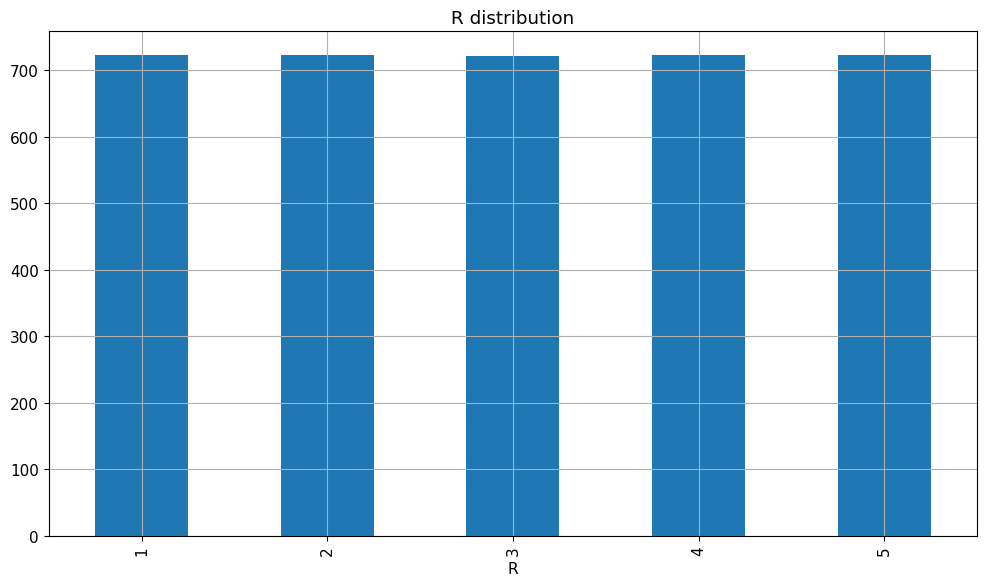

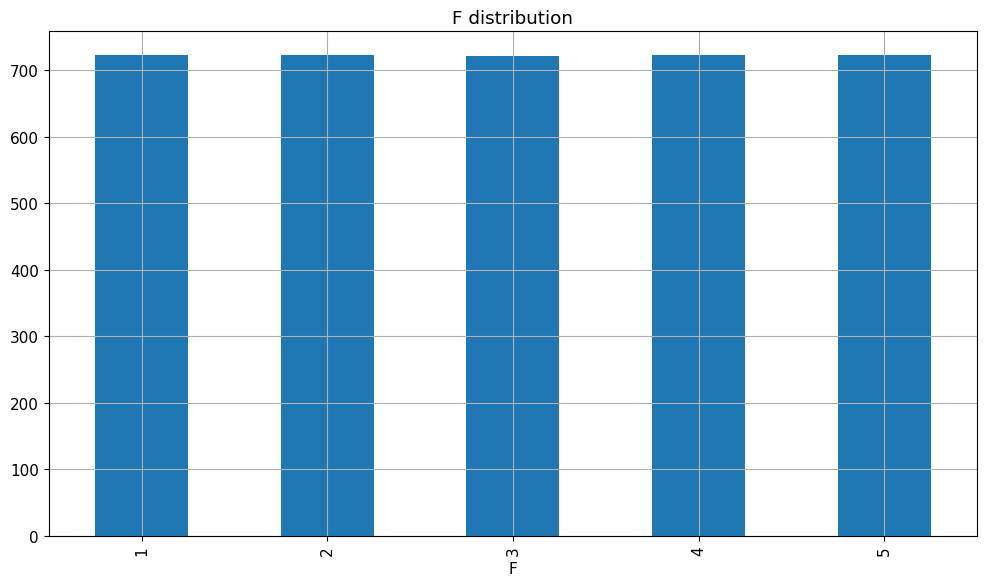

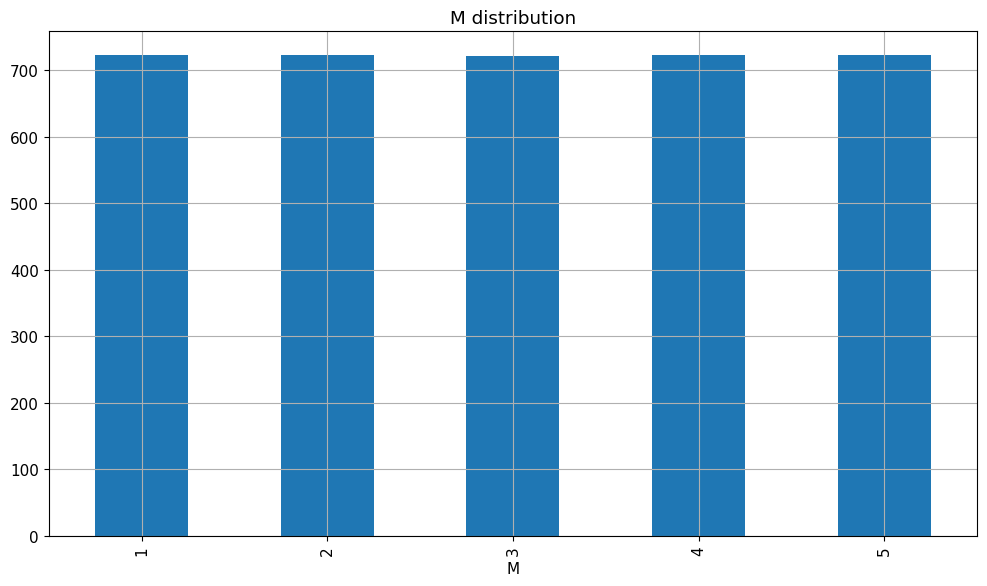

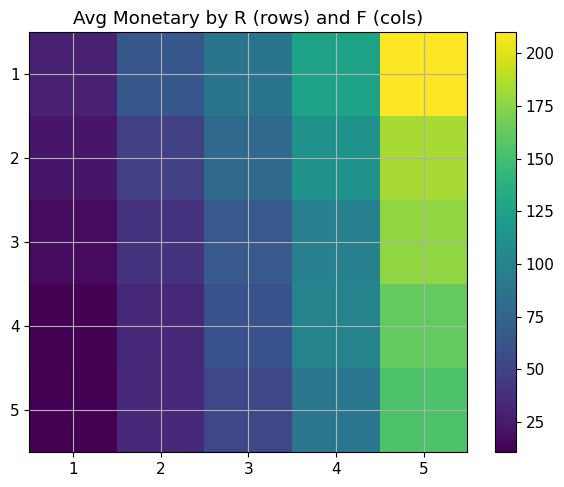

Saved: rfm_scores.csv


In [31]:
R_col = 'min_MnthAfterLoan' if 'min_MnthAfterLoan' in vitrine.columns else None
F_col = 'all_credits' if 'all_credits' in vitrine.columns else None
M_col = 'sum_of_paym_months' if 'sum_of_paym_months' in vitrine.columns else None
print("R/F/M columns:", R_col, F_col, M_col)

rfm = vitrine.copy()
def quantile_score(x, q=5, reverse=False):
    ranks = pd.qcut(x.rank(method='first'), q, labels=False, duplicates='drop') + 1
    ranks = ranks.astype(int)
    return (q+1 - ranks) if reverse else ranks

if R_col: rfm['R'] = quantile_score(rfm[R_col].fillna(rfm[R_col].max()), q=5, reverse=True)
if F_col: rfm['F'] = quantile_score(rfm[F_col].fillna(0), q=5, reverse=False)
if M_col: rfm['M'] = quantile_score(rfm[M_col].fillna(0), q=5, reverse=False)

if all(c in rfm.columns for c in ['R','F','M']):
    rfm['RFM'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)
    print("Unique RFM codes:", rfm['RFM'].nunique())
    top = rfm['RFM'].value_counts().head(15)
    display(top)

    plt.figure(); rfm['R'].value_counts().sort_index().plot(kind='bar'); plt.title('R distribution'); plt.tight_layout(); plt.show()
    plt.figure(); rfm['F'].value_counts().sort_index().plot(kind='bar'); plt.title('F distribution'); plt.tight_layout(); plt.show()
    plt.figure(); rfm['M'].value_counts().sort_index().plot(kind='bar'); plt.title('M distribution'); plt.tight_layout(); plt.show()

    # Heatmap: average M by R×F
    if R_col and F_col and M_col:
        pivot = rfm.pivot_table(index='R', columns='F', values=M_col, aggfunc='mean')
        plt.figure(figsize=(6,5)); plt.imshow(pivot.values, aspect='auto', interpolation='nearest'); plt.colorbar()
        plt.title('Avg Monetary by R (rows) and F (cols)')
        plt.xticks(range(pivot.shape[1]), list(pivot.columns)); plt.yticks(range(pivot.shape[0]), list(pivot.index))
        plt.tight_layout(); plt.show()

    rfm[['R','F','M','RFM']].to_csv('rfm_scores.csv', index=False)
    print("Saved: rfm_scores.csv")
else:
    print("RFM not fully constructed due to missing columns.")

## Conclusions & Exports
- Robust CSV import prevents the single-column issue (detected delimiter & decimal).
- Extensive EDA, improved visuals, PCA + metrics, t-SNE, detailed cluster profiling, and RFM with heatmap.
- Exports: `vitrine_clean.csv`, `clusters_kmeans.csv`, `rfm_scores.csv`.
